# Setting up

In [87]:
# Default imports
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML
import joblib
import os
import math

# Pre processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import f_classif, chi2
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from scipy.stats import shapiro, boxcox, pearsonr, anderson
from scipy.special import inv_boxcox
from scipy.stats import kurtosis, skew

# Sampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline, make_pipeline as imb_make_pipeline

# Model evaluation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, RocCurveDisplay
from sklearn.metrics.cluster import contingency_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict
from hyperopt import hp, fmin, tpe, space_eval
from sklearn.decomposition import PCA
import shap


# Models
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, MeanShift, OPTICS, Birch, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
import xgboost as xgboost
import lightgbm as lgboost
import catboost as catboost

# PyTorch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import torch
import torch.nn.functional as F
from hyperopt import Trials

import warnings
warnings.filterwarnings('ignore')


In [88]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [89]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

- Make an introduction
- Methodology : Now that we have extracted interesting features, we are going to optimize them for our algorithms through a process called feature engineering (with transformations and new features). Then, we are going to test several algorithms on our data in order to predict the bug type. We will try to use different parts of our feature engineering process for each algorithm in order to find which processes work best for each algorithm. We will proceed from the algorithms which we expect to have the worse results to the algorithm which we expect to be the most effective.

# A - Feature Engineering

# 1. Initial preparation of data

#### Load the data and variables

In [90]:
path = 'data/'
data = pd.read_csv(path + "processed_data.csv",header=0,index_col='ID')
print(data.shape)
data.head(10)

(249, 138)


,bug_type,species,nb_pixels_ratio,image_symmetry_index,mask_bb_symmetry_index,roundness,mean_centroid_distance,std_centroid_distance,max_centroid_distance,min_centroid_distance,skewness_centroid_distance,kurtosis_centroid_distance,aspect_ratio,mask_area,mask_perimeter,mask_compactness,hull_area,hull_to_insect_area_ratio,hull_convexity,hull_triangle_similarity,ellipse_angle,ellipse_axis_ratio,ellipse_eccentricity,ellipse_variance,axis_least_inertia_x,axis_least_inertia_y,rectangularity,body_parts_mean_length,body_parts_max_length,body_parts_std_length,body_parts_spread,rest_entropy,mask_entropy,red_mask_min,red_rest_min,red_mask_max,red_rest_max,red_mask_mean,red_rest_mean,red_mask_median,red_rest_median,red_mask_std,red_rest_std,red_mask_q1,red_rest_q1,red_mask_q3,red_rest_q3,green_mask_min,green_rest_min,green_mask_max,green_rest_max,green_mask_mean,green_rest_mean,green_mask_median,green_rest_median,green_mask_std,green_rest_std,green_mask_q1,green_rest_q1,green_mask_q3,green_rest_q3,blue_mask_min,blue_rest_min,blue_mask_max,blue_rest_max,blue_mask_mean,blue_rest_mean,blue_mask_median,blue_rest_median,blue_mask_std,blue_rest_std,blue_mask_q1,blue_rest_q1,blue_mask_q3,blue_rest_q3,hue_mask_min,hue_rest_min,hue_mask_max,hue_rest_max,hue_mask_mean,hue_rest_mean,hue_mask_median,hue_rest_median,hue_mask_std,hue_rest_std,hue_mask_q1,hue_rest_q1,hue_mask_q3,hue_rest_q3,saturation_mask_min,saturation_rest_min,saturation_mask_max,saturation_rest_max,saturation_mask_mean,saturation_rest_mean,saturation_mask_median,saturation_rest_median,saturation_mask_std,saturation_rest_std,saturation_mask_q1,saturation_rest_q1,saturation_mask_q3,saturation_rest_q3,value_mask_min,value_rest_min,value_mask_max,value_rest_max,value_mask_mean,value_rest_mean,value_mask_median,value_rest_median,value_mask_std,value_rest_std,value_mask_q1,value_rest_q1,value_mask_q3,value_rest_q3,fourier_descriptor_real_0,fourier_descriptor_imag_0,fourier_descriptor_real_1,fourier_descriptor_imag_1,fourier_descriptor_real_2,fourier_descriptor_imag_2,fourier_descriptor_real_3,fourier_descriptor_imag_3,fourier_descriptor_real_4,fourier_descriptor_imag_4,fourier_descriptor_real_5,fourier_descriptor_imag_5,fourier_descriptor_real_6,fourier_descriptor_imag_6,fourier_descriptor_real_7,fourier_descriptor_imag_7,fourier_descriptor_real_8,fourier_descriptor_imag_8,fourier_descriptor_real_9,fourier_descriptor_imag_9,orthogonal_lines_ratio
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Bee,Apis mellifera,0.007199,65.842518,70.059270,0.046706,245.172338,55.348483,362.548639,127.671981,-0.057930,-0.817833,0.811060,172773,6818,0.046706,265227.5,0.651414,0.286969,0.826408,4.100518,0.878376,0.477971,0.099935,-0.840749,0.541425,0.502645,434.179165,1566.469267,545.078940,252.452196,7.460814,6.967513,5,1,203,255,66.750522,107.403577,54,128,47.329372,61.073311,26,43,99,156,3,2,199,255,53.387028,105.378123,36,123,44.415601,58.068684,17,49,81,151,0,0,186,255,38.786193,84.573068,23,85,35.298702,57.198890,13,28,54,132,0,0,178,179,22.955340,42.776885,14,27,35.494402,46.076375,10,21,20,38,0,0,255,255,113.963825,66.078872,115.0,51,41.474470,50.351267,83,26,143,102,5,3,203,255,66.826408,109.176003,55,128,47.295039,59.737595,26,50,99,156,0.802350,0.596853,-0.025349,-0.008629,-0.013720,0.006373,-0.001826,-0.004257,-0.010642,0.004364,-0.001702,0.008064,-0.001693,0.002286,-0.003509,0.004708,-0.000954,0.001356,-0.002313,0.000987,0.679289
2,Bee,Apis mellifera,0.008306,68.896841,40.143673,0.048440,279.998031,85.163883,478.802953,108.009513,-0.063210,-0.616582,0.652482,199332,7191,0.048440,350945.5,0.567986,0.320907,0.997932,5.416759,0.568091,0.822966,0.090493,-0.965743,0.259500,0.426842,632.800093,4440.118453,1357.730195,350.976352,7.471152,6.811326,2,0,248,255,62.015547,101.106455,54,120,41.367330,61.737563,25,36,95,151,2,1,251,255,50.140876,98.708295,32,116,41.829106,58.443197,16,42,81,145,0,0,244,255,34.0956

In [91]:
RANDOM_STATE = 10

### a) Removal of useless or negatively impactful information

In [92]:
data.bug_type.value_counts()

bug_type
Bee          115
Bumblebee    100
Butterfly     15
Hover fly      9
Wasp           9
Dragonfly      1
Name: count, dtype: int64

Dropping mask_compactness column because it is the same as roundness

In [94]:
data = data.drop(['mask_compactness'], axis=1)

We will also drop the dragonfly column for now just to see how we do on the other bugs

In [ ]:
dragonfly_data = data[data.bug_type == 'dragonfly']
data = data[data.bug_type != 'dragonfly']
#data.shape, data_with_dragonfly.shape
# (careful : this code was reimplemented after being deleted and wasnt retested)

Dropping columns that are constant and equal to 0 that we identified during visualisation. They are useless since their value doesn't vary

In [95]:
for col in data.columns:
    col_sum = data[col].sum()
    if col_sum == 0:
        print('Dropped column because completely null:', col)
        data.drop(col, axis=1, inplace=True)

Dropped column because completely null: hue_mask_min
Dropped column because completely null: hue_rest_min


#find columns which always have the same value
cols_to_drop = []
for col in X.columns:
    if X[col].nunique() == 1:
        cols_to_drop.append(col)
cols_to_drop

### b) Our process to test algorithms

We will use cross validation to train and test our algorithms because (to complete). We chose a cross validation with 4 splits instead of 5 because of the low number of samples. We will also ensure that our each train and test split of our folds contain a sufficient number of samples from each class, since our target is imbalanced and we want to make sure that we are training and testing our model on predicting all classes. We set this number to 2.

In [96]:
# Preparing the variables
X = data.drop(columns=['bug_type','species'])
scaled_X = StandardScaler().fit_transform(X)
X2 = pd.DataFrame(scaled_X, columns=X.columns)
pca = PCA(n_components=2)
proj_X = pca.fit_transform(scaled_X)
target = 'bug_type'
y = data[target]
labelencoder = LabelEncoder()
y_encoded = labelencoder.fit_transform(y)
classes = np.unique(y)
n_classes = len(classes)

In [98]:
# Preparing the folds for training with 4 splits
cv = StratifiedKFold(n_splits=4, random_state=2, shuffle=True)

def check_splits(X, y, cv, min_samples_per_class_in_train=3, min_samples_per_class_in_test=2):
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Ensure we have at least 2 instances of each class in each set
        for class_name in np.unique(y):
            if class_name == 'Dragonfly':
                continue
            if len(y_train[y_train == class_name]) < min_samples_per_class_in_train:
                print(f"Train set has less than {min_samples_per_class_in_train} instances of class", class_name)
            if len(y_test[y_test == class_name]) < min_samples_per_class_in_test:
                print(f"Test set has less than {min_samples_per_class_in_test} instances of class", class_name)
check_splits(X, y, cv)

#### Utility Functions (skip to next part for feature engineering and model evaluation)

In [99]:
### FEATURE SELECTION VISUALISATION TOOLKIT ###
def make_graph(forest_importances, std, ax, n_features, asc=False):
    forest_importances2 = forest_importances.sort_values(ascending=asc)
    if n_features is not None:
        forest_importances2 = forest_importances2[:n_features]
        std2 = std[:n_features] if std is not None else None

    forest_importances2.plot.bar(yerr=std2, ax=ax)
    way = "Bottom " if asc else "Top "
    ax.set_title("Feature importances using MDI ({0} {1})".format(way, n_features if n_features is not None else ""))
    ax.set_ylabel("Importance")
    plt.xticks(rotation=45, ha='right')
    #ax.xaxis.set_tick_params(rotation=45, ha='right')

def plot_feature_importances(model, X, n_features=50, plot_bottom=True):
    importances = model.feature_importances_
    if hasattr(model, 'estimators_'):
        std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    else:
        std = None  # No standard deviation if the model doesn't support it

    forest_importances = pd.Series(importances, index=X.columns)
    total_n_features = len(X.columns)
    length = 10
    if plot_bottom:
        n = 2
        length *= 2
    else: n=1
    fig, axs = plt.subplots(figsize=(15, length), nrows=n, ncols=1)
    ax = axs if n == 1 else axs[0]
    make_graph(forest_importances, std, ax, n_features, asc=False)
    if n == 2:
        make_graph(forest_importances, std, axs[1], total_n_features - n_features, asc=True)
    fig.tight_layout()
    plt.show()

def plot_shap_values(model, X, n_features=10):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, plot_type="bar", max_display=X.shape[1]-2)

In [100]:
### MODEL PERFORMANCE VISUALIZATION TOOLKIT ###
def plot_predictions(predicted_class, actual_class):
    global proj_X
    fig, ax = plt.subplots(figsize=(6, 6))
    predicted_class = "predicted_" + predicted_class
    actual_class = "actual_" + actual_class
    print(type(proj_X),  type(predicted_class), type(actual_class))
    sns.scatterplot(x=proj_X[:, 0], y=proj_X[:, 1], hue=predicted_class, style=actual_class, ax=ax)

    # Add labels and legend
    plt.xlabel('PC1 (explained variance: {0})'.format(pca.explained_variance_ratio_[0]))
    plt.ylabel('PC2 (explained variance: {0})'.format(pca.explained_variance_ratio_[1]))
    plt.title('Predicted vs Actual Class')
    plt.legend()

    # Show the plot
    plt.show()

from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_multiclass_roc(y, y_proba, classes, n_classes):
    # Binarize the output
    y_bin = label_binarize(y, classes=classes)
    n_classes = y_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(classes[i], roc_auc[i]))

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    plt.show()

from sklearn.metrics import average_precision_score
def plot_multiclass_precision_recall(y, y_proba, classes, n_classes):
    # Binarize the output
    y_bin = label_binarize(y, classes=classes)
    n_classes = y_bin.shape[1]

    # Create a color cycle to differentiate classes
    colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue'])

    # Set up plot
    plt.figure(figsize=(10, 8))
    lines = []
    labels = []

    # Compute Precision-Recall and plot curve for each class
    for i, color in zip(range(n_classes), colors):
        precision, recall, _ = precision_recall_curve(y_bin[:, i], y_proba[:, i])
        average_precision = average_precision_score(y_bin[:, i], y_proba[:, i])
        l, = plt.plot(recall, precision, color=color, lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'.format(classes[i], average_precision))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multi-class Precision-Recall curve')
    plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14), fontsize=10)
    # adjust legend label size
    
    plt.show()

from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [101]:
### FINAL MODEL EVLUATION FUNCTION ###
def evaluate_predictions(model,y,y_pred, y_encoded, plot, y_proba=None):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    classes = model.classes_ if hasattr(model, 'classes_') else np.unique(y)
    print(classification_report(y, y_pred, target_names=classes))

    # Plot confusion matrix
    cm = confusion_matrix(y, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    if plot :
        if (y_proba is not None):
            plot_multiclass_roc(y, y_proba, classes, n_classes)
            plot_multiclass_precision_recall(y, y_proba, classes, n_classes)
            plot_learning_curve(model, "Learning Curve", X, y_encoded, cv=cv, n_jobs=-1)
        actual_model = model.named_steps['model']
        if hasattr(actual_model, 'feature_importances_'):
            plot_shap_values(actual_model, X, n_features=10)
    plt.show()
    return accuracy

search_space = {
    'C': hp.loguniform('C', np.log(0.01), np.log(100)),  # Regularization strength
    'penalty': hp.choice('penalty', [ 'l2']),
    'solver': hp.choice('solver', ['lbfgs', 'liblinear'])
}
log = imbPipeline([ 
    ('model', LogisticRegression())])
best_params = optimize_classifier(X, y, log, search_space,{}, max_evals=150, scoring='accuracy')
#{'C': 0.02544670436123156, 'penalty': 'l2', 'solver': 'liblinear'}

rf = RandomForestClassifier(random_state=RANDOM_STATE)
pipe = imbPipeline({
    ('scaler', StandardScaler()),
    ('model', rf)
})
evaluate_classifier(pipe, X, y)

In [183]:
### CLASSIFICATION TOOLKIT ###

def evaluate_classifier(pipeline, X, y, plot=False, debug=False, n_jobs=-1, return_score=False, cv=cv):
    if y.dtype == 'object':
        y_encoded = labelencoder.fit_transform(y)
    else:
        y_encoded = y
    # Perform cross-validated prediction
    class_name = pipeline.named_steps['model'].__class__.__name__ 
    is_pytorch = class_name == 'PyTorchClassifier'
    if is_pytorch and len(pipeline.named_steps) == 1:
        X2 = X.values
    else:
        X2 = X
    y_pred_cv = cross_val_predict(pipeline, X2, y_encoded, cv=cv, n_jobs=n_jobs)

    # Decode the predictions
    y_pred_cv_decoded = labelencoder.inverse_transform(y_pred_cv)

    if plot and (hasattr(pipeline.named_steps['model'], 'predict_proba')):
        y_proba_cv = cross_val_predict(pipeline, X2, y_encoded, cv=cv, n_jobs=n_jobs, method='predict_proba')
    else:
        y_proba_cv = None
    if debug:
        print("Actual target values:", y)
        print("Predicted target values:", y_pred_cv_decoded)
        if y_proba_cv is not None:
            print("Predicted probabilities:", y_proba_cv)
    if return_score:
        return evaluate_predictions(pipeline, y, y_pred_cv_decoded, y_encoded, plot, y_proba=y_proba_cv)
    evaluate_predictions(pipeline, y, y_pred_cv_decoded, y_encoded, plot, y_proba=y_proba_cv)

def search_parameters(obj_func, search_space, max_evals=100):
    best = fmin(obj_func, search_space, algo=tpe.suggest, max_evals=max_evals)
    space_evaluation = space_eval(search_space, best)
    print("Best hyperparameters:", space_evaluation)
    return space_evaluation

def adapt_sampling_strategy(pipeline, params, define_sampling_strategy_for):
    sampling_strat = {}
    params_to_drop = []
    for param, value in params.items():
        model_strategy_param_str = define_sampling_strategy_for + '__strategy'
        model_strategy_param_str_len = len(model_strategy_param_str)
        if param[:model_strategy_param_str_len] == model_strategy_param_str:
            sampling_strat[int(param[model_strategy_param_str_len+2:])] = value
            params_to_drop.append(param)
    #print(params_to_drop)
    for param in params_to_drop:
        params.pop(param)
    pipeline.named_steps[define_sampling_strategy_for].sampling_strategy = sampling_strat
    #print(pipeline.named_steps[define_sampling_strategy_for].sampling_strategy)
    return params

def get_layers_sizes(input_size, num_layers, compression_ratio, min_layer_size):
    sizes = [input_size]  # Start with the input size
    for i in range(num_layers - 1):
        next_size = int(sizes[-1] * compression_ratio)
        next_size = max(next_size, min_layer_size)  # Ensure the size doesn't drop below minimum
        sizes.append(next_size)
    print(sizes)
    return sizes[1:] 

def sample_layers_sizes(num_layers, units_per_layer):
    return [units_per_layer[i] for i in range(num_layers)]

def adapt_pytorch_layers_sizes(X,params):
    input_size = X.shape[1]
    num_layers = params.pop('num_layers', None)
    if 'units_per_layer' in params:
        units_per_layer = params.pop('units_per_layer', None)
        if num_layers is not None and units_per_layer is not None:
            params['model__layers_sizes'] = sample_layers_sizes(num_layers, units_per_layer)
    elif 'compression_ratio' in params:
        compression_ratio = params.pop('compression_ratio', None)
        min_layer_size = params.pop('min_layer_size', None)
        if num_layers is not None and compression_ratio is not None and min_layer_size is not None:
            params['model__layers_sizes'] = get_layers_sizes(input_size, num_layers, compression_ratio, min_layer_size)
    return params

def adapt_feature_selection(X, params):
    feature_flags = {key.replace('select__', ''): value for key, value in params.items() if 'select__' in key}
    for key in list(params.keys()):
        if 'select__' in key:
            del params[key]
    params['feature_selector__feature_flags'] = feature_flags
    return params

def objective(pipeline, params, X, y, cv, scoring, random_state, define_sampling_strategy_for, is_pytorch=False, n_jobs=-1):
    # The params dictionary contains keys like 'model__max_depth' and 'smote__strategy'
    if 'feature_selector' in pipeline.named_steps:
        adapt_feature_selection(X, params)
        
    if is_pytorch:
        params = adapt_pytorch_layers_sizes(X, params)
    # Define the sampling strategy for SMOTE
    if define_sampling_strategy_for is not None:
        adapt_sampling_strategy(pipeline, params, define_sampling_strategy_for)

    # Set the parameters of the pipeline
    if hasattr(pipeline.named_steps['model'], 'random_state'):
        pipeline.named_steps['model'].random_state = random_state
    pipeline.set_params(**params)
    
    # Calculate score over the predefined folds
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    # Return the negative mean accuracy because the function is minimized
    return -scores.mean()

def optimize_classifier(X, y, y, pipeline, model_params_space, pipeline_params_space, max_evals=100, scoring='accuracy', 
            random_state=RANDOM_STATE, n_jobs=-1, search_features=False):
    if y.dtype == 'object':
        y_encoded = labelencoder.fit_transform(y)
    else:
        y_encoded = y
    # Merge the model parameters space with the pipeline parameters space
    feature_space = {f'select__{col}': hp.choice(f'select__{col}', [0, 1]) for col in X.columns}
    model_name = pipeline.named_steps['model'].__class__.__name__
    if model_name == 'OneVsRestClassifier':
        # add "estimator__" prefix to the model parameters
        model_space = {'model__estimator__' + k: v for k, v in model_params_space.items()}
    else:
        model_space = {'model__' + k: v for k, v in model_params_space.items()}
    search_space = {**model_space, **pipeline_params_space, **feature_space}

    print("Search space:", search_space)
    define_sampling_strategy_for = None
    for key in search_space.keys():
        for over_sampling_model in ['smote', 'adasyn', 'random']:
            model_str = over_sampling_model
            model_str_len = len(model_str)
            if key[:model_str_len] == over_sampling_model:
                define_sampling_strategy_for = over_sampling_model
                break
    is_pytorch = pipeline.named_steps['model'].__class__.__name__ == 'PyTorchClassifier'
    if is_pytorch and (len(pipeline.named_steps) == 1):
        X2 = X.values
    else:
        X2 = X
    obj_func = lambda params: objective(pipeline, params, X2, y_encoded, cv, scoring, random_state, define_sampling_strategy_for, is_pytorch=is_pytorch, n_jobs=n_jobs)
    best_params = search_parameters(obj_func, search_space, max_evals)
    if define_sampling_strategy_for is not None:
        best_params = adapt_sampling_strategy(pipeline, best_params, define_sampling_strategy_for)
    if is_pytorch:
        best_params = adapt_pytorch_layers_sizes(X, best_params)
    if search_features:
        best_params = adapt_feature_selection(X, best_params)
        feature_flags = best_params['feature_selector__feature_flags']
        print("Selected {0} features out of {1} :".format(sum(feature_flags.values()), len(feature_flags)))
        print([key for key, value in feature_flags.items() if value == 1])
    pipeline.set_params(**best_params)
    return best_params

In [103]:
### CLUSTERING TOOLKIT ###

from sklearn.preprocessing import LabelEncoder
def majority_vote(clusters, labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    y_pred = np.zeros_like(clusters)
    unique_clusters = np.unique(clusters)
    #print(np.unique(unique_clusters), np.unique(labels))
    for cluster in unique_clusters:
        cluster_indices = np.where(clusters == cluster)[0]
        cluster_labels = labels[cluster_indices]
        majority_label = np.argmax(np.bincount(cluster_labels))
        y_pred[cluster_indices] = majority_label
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    return y_pred_decoded


def evaluate_clustering(model,X,labels, plot=False):
    # Fit the model and predict cluster labels
    model.fit(X)
    cluster_labels = model.labels_

    # Evaluate clustering performance
    silhouette_index = silhouette_score(X, cluster_labels,metric='euclidean')
    print("Silhouette score : ", silhouette_index)

    # Perform majority voting using encoded labels then decode
    y_pred = majority_vote(cluster_labels, labels)

    # Evaluate predictions as if it were a classification task
    evaluate_predictions(model, labels, y_pred, plot)

    if plot:
        # Create a scatter plot of the projected data with color-coded clusters
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=cluster_labels,style=labels, palette='viridis')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('{0} clustering results '.format(model.__name__))
        plt.show()

from sklearn.metrics import get_scorer
def cluster_objective(model, params, X, y, cv, scoring, random_state):
    model.set_params(**params)
    model.fit(X)
    cluster_labels = model.labels_
    y_pred = majority_vote(cluster_labels, y)
    #scorer = get_scorer(scoring)
    #score = scorer._score_func(y, y_pred)
    score = accuracy_score(y,y_pred)
    print(score)
    return -score
    
def optimize_clustering(model, search_space, max_evals=100, scoring='accuracy', random_state=RANDOM_STATE):
    if hasattr(model, 'random_state'):
        model.random_state = random_state 
    if hasattr(model, 'n_clusters'):
        model.n_clusters = n_classes
    print(model.random_state)
    obj_func = lambda params: cluster_objective(model, params, X, y, cv, scoring, random_state)
    best_params = search_parameters(obj_func, search_space, max_evals)
    if hasattr(model, 'random_state'):
        best_params['random_state'] = random_state
    if hasattr(model, 'n_clusters'):
        best_params['n_clusters'] = n_classes
    model.set_params(**best_params)
    print(model.random_state)
    return best_params

In [104]:
### FEATURE ENGINEERING TOOLKIT ###
def identity(x):
    return x
    
def inverse(x):
    return 1 / (x + 1)  # Adding 1 to avoid dividing by zero

def square(x):
    return x ** 2

def cube(x):
    return x ** 3

def log_on_minmax(x):
    scaled = (x - np.min(x)) / (np.max(x) - np.min(x))
    return np.log1p(scaled)

# Creating transformation functions
def safe_log(x):
    return np.log1p(np.maximum(x, 0))  # Safely log transform data

def power_transform_factory(x,power, max_acceptable_value=1e8):
    if np.any(x < 0):
        # if power is not integer then x has to be non-negative
        if not power.is_integer():
            raise ValueError("Data contains negative values that cause error in power transform")
        # if power is even, then x should be non-negative  so that power doesn't lose information
        if power % 2 != 0:
            raise ValueError("Data contains negative values, which is not ideal for even power transform")
    if power < 0:
        if np.any(x == 0): raise ValueError("Data contains zero values that cause error with negative power transform")
        transformed_x = np.float_power(x, power)
    else:
        transformed_x = np.power(x, power)
    if np.any(transformed_x > max_acceptable_value): raise ValueError("Data contains values that cause too large values in power transform")
    return transformed_x

def tanh_transform(x):
    return np.tanh(x)

def sigmoid_transform(x, overflow_clip=12):
    if np.any(np.abs(x) > overflow_clip): raise ValueError("Data contains values that cause overflow in sigmoid transform")
    return 1 / (1 + np.exp(-x))

def box_cox_transform(x):
    if np.any(x <= 0): raise ValueError("Data contains non-positive values that cause error in boxcox transform")
    return boxcox(x)[0]

def arcsinh_transform(x):
    return np.arcsinh(x)

def cosh_transform(x, overflow_clip=12):
    return np.cosh(x)

def exponential_transform(x, overflow_clip=12):
    if np.any(x > overflow_clip): raise ValueError("Data contains values that cause overflow in exponential transform")
    return np.exp(x)
    
def box_cox_transform(x):
    # if most values are negative, boxcox is useless so we throw an error if it is the case
    if np.sum(x > 0) < 0.5 * len(x):
        raise ValueError("Data contains too many negative values for Box-Cox transformation")
    positive_x = np.maximum(x + 1, 1)  # Shift to positive to apply Box-Cox
    return boxcox(positive_x)[0]

def z_score_normalization(x):
    return (x - np.mean(x)) / np.std(x)

def rank_transform(x):
    return np.argsort(np.argsort(x))

from scipy.stats import yeojohnson
def yeo_johnson_transform(x):
    return yeojohnson(x)[0]

def create_transformations_dict(add_advanced_transforms=False):
    # Powers can range from -2 to 2, for example, in 0.5 increments
    powers = np.arange(-2, 2.1, 0.5)
    # drop 0 from powers
    power_transformations = {f'power_{p}': lambda x, p=p: power_transform_factory(x, p) for p in powers}
    del power_transformations['power_0.0']
    del power_transformations['power_1.0']
    transformations = {
    'log': safe_log,
    }
    transformations.update(power_transformations)
    if add_advanced_transforms:
        transformations.update(**{
            'log_square': lambda x: safe_log(power_transform_factory(x,2.0)),
            'log_sqrt': lambda x: safe_log(power_transform_factory(x,0.5)),
            'tanh': tanh_transform,
            'sigmoid': sigmoid_transform,
            #'box_cox': box_cox_transform,
            #'arcsinh': arcsinh_transform,
            #'cosh': cosh_transform
        })
    return transformations

def custom_normality_score(skewness, kurtosis):
    # Normalizing skewness where 0 is perfect (no skew)
    normalized_skewness = 1 / (1 + abs(skewness))
    
    # Normalizing kurtosis where 3 is perfect (normal tails)
    normalized_kurtosis = 1 / (1 + abs(kurtosis - 3))
    
    # Combine the two normalized values into one score
    return (normalized_skewness + normalized_kurtosis) / 2

def get_majority_classes_and_arrays(y, min_size=20):
    y_list = []
    for label in np.unique(y):
        is_label = y == label
        if np.sum(is_label) >= min_size:
            y_list.append(is_label)
    return y_list

def find_best_transformation(df, target_2d, transformations, cv=cv, scoring='f_classif', goal='classification', 
                             verbose=False, display_df=True, debug=False):
    if 'identity' in transformations:
        transformations.pop('identity')
    transformations = {'identity': identity, **transformations}
    scoring_to_minimal_score_gain = {
        'f_classif': 0.07,
        'mutual_info': 0.01,
        'pearson': 0.07,
        'chi2': 0.07,
        'logistic_regression': 0.02,
        'skewness_kurtosis': 0.15,
        'shapiro': 0.15, 
        'anderson': 0.15, 
        'gaussian_bayes': 0.05,
    }
    try:
        minimal_score_gain_from_default_col = scoring_to_minimal_score_gain[scoring]
    except KeyError:
        pass
    target = target_2d.squeeze()
    #print(target.shape)
    best_transforms = {}
    best_transform_names = {}
    columns = df.columns if not debug else df.columns[:2]
    for column in columns:
        if is_numeric_dtype(df[column]):
            best_score = -np.inf
            best_trans_name = None
            best_trans_func = None
            for trans_name, trans_func in transformations.items():
                if verbose: print(f'Applying transformation {trans_name} to column {column}')
                try:
                    transformed_data = trans_func(df[column].values.copy())# remove copy
                    transformed_data_2d = transformed_data.reshape(-1, 1)
                except ValueError as e:
                    if verbose: print(f"Error transforming {trans_name} for column {column}: {e}")
                    continue
                if np.any(np.isnan(transformed_data) | np.isinf(transformed_data) | np.isneginf(transformed_data)):
                    if verbose: print(f"Warning: column {column} cannot be transformed with {trans_name} because it contains NaN or Inf values")
                    continue
                try:
                    transformer = FunctionTransformer(lambda x: trans_func(x).reshape(-1, 1))
                    #transformed_data = transformer.fit_transform(df[[column]])
                    if goal == 'classification':
                        ### FOR MODELS USING LINEAR RELATIONSHIPS ###
                        if scoring == 'f_classif':
                            score = f_classif(transformed_data_2d, target)[0][0]
                        elif scoring == 'mutual_info':
                            score = mutual_info_score(transformed_data, target)
                        elif scoring == 'pearson':
                            separated_classes = [target == c for c in np.unique(target)]
                            score = np.mean([np.abs(pearsonr(transformed_data, c)[0]) for c in separated_classes])
                            #classes_arr = get_majority_classes_and_arrays(y,min_size=20)
                            #score = np.mean([np.abs(pearsonr(transformed_data, c)[0]) for c in classes_arr])
                            #print(score)
                        elif scoring == 'chi2':
                            score = chi2(transformed_data_2d, target)[0][0]
                        elif scoring == 'logistic_regression':
                            model = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, max_iter=50)
                            score = cross_val_score(model, transformed_data_2d, target, cv=cv, scoring='accuracy').mean()
                        ### FOR MODELS USING GAUSSIAN DISTRIBUTIONS ###
                        elif scoring == 'shapiro':
                            score = np.mean([shapiro(transformed_data[target == c])[1] for c in np.unique(target)])
                            #majority_arr, majority_classes = get_majority_classes_and_arrays(transformed_data)
                            #score = np.mean([shapiro(majority_arr[i])[1] for i in range(len(majority_arr))])
                        elif scoring == 'anderson':
                            score = np.mean([anderson(transformed_data[target == c])[0] for c in np.unique(target)])
                        elif scoring == 'skewness_kurtosis':
                            skewness = skew(transformed_data)
                            kurtosis_value = kurtosis(transformed_data)
                            score = custom_normality_score(skewness, kurtosis_value)
                        elif scoring == 'gaussian_bayes':
                            model = GaussianNB()
                            score = cross_val_score(model, transformed_data_2d, target, cv=cv, scoring='accuracy').mean()
                        else:
                            raise ValueError(f"Invalid scoring method {scoring} for classification")
                    else:
                        # pearson correlation
                        score = np.abs(pearsonr(transformed_data, target)[0])
                    #print(trans_name)
                    #print(f"Transformed Data Sample: {transformed_data[:5].flatten()}")
                    if (np.isnan(score)) | np.isinf(score) | np.isneginf(score):
                        if verbose: print(f"Warning: score of {trans_name} of {column} was not computed correctly ({score})")
                        continue
                    if score > best_score:
                        if (trans_name == 'identity') and (minimal_score_gain_from_default_col is not None):
                            best_score = (1 + minimal_score_gain_from_default_col) * score
                        else:
                            best_score = score
                        best_trans_name = trans_name
                        best_trans_func = trans_func
                except Exception as e:
                    if verbose: print(f"Error transforming  {column} with {trans_name}: {e} ")
                    continue  # Handle errors in transformation or scoring computation
            best_transforms[column] = (best_trans_func, best_score)
            best_transform_names[column] = best_trans_name
            #if best_score < min_score_for_acceptance: print(f"Warning: no transformation for {column} achieved a score of {min_score_for_acceptance} or higher")
        else:
            if verbose:
                print(f"{column} is not a numeric column (has data type {df[col].dtype}")
    # Dataframe of score and acceptance
    df_results = pd.DataFrame(best_transforms).T
    df_results.drop(columns=0, inplace=True)
    df_results.columns = ['score']
    df_results.index.name = 'column'
    df_results['transformation_name'] = best_transform_names.values()
    #print(df_results['score'])
    score_mean = df_results['score'].mean()
    df_results['above_mean'] = df_results['score'] > score_mean
    print(f'{df_results["above_mean"].sum()} transformations with score above mean ({score_mean}) out of {df_results.shape[0]} ({df_results["above_mean"].mean():.2%})')
    print(f"Counts for each transformation for scoring {scoring}:", df_results['transformation_name'].value_counts())
    print(f"Information on scores : ", df_results['score'].describe())
    df_results = df_results.sort_values('score', ascending=False)
    if display_df: 
        print(f"Best transformations for each column:")
        display(HTML(df_results.to_html()))
    return best_transforms, df_results

from sklearn.base import BaseEstimator, TransformerMixin
class MultiColumnCachedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformations, min_score_for_acceptance=0.2, verbose=False,
                     columns_to_apply_to=None, transf_dict_contains_score=True):
        """
        transformations: dict
            A dictionary mapping column names to transformation functions.
        """
        self.transformations = transformations
        self.columns_to_apply_to = columns_to_apply_to
        self.min_score_for_acceptance = min_score_for_acceptance
        self.cache_ = {}
        self.verbose = verbose
        self.transf_dict_contains_score = transf_dict_contains_score
        

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Create a unique hash based on the input DataFrame
        if self.verbose: print(f"Transforming data of shape {X.shape}")
        n_samples = X.shape[0]
        transformed_data = X.copy()
        applicable_columns = self.columns_to_apply_to if self.columns_to_apply_to is not None else X.columns
        n = 0
        for column in applicable_columns:
            if column not in transformed_data.columns:
                if self.verbose: print(f"Skipping column {column} because it is not in the input data")
                continue
            if self.transf_dict_contains_score:
                func, score = self.transformations.get(column, (None, None))
                if score < self.min_score_for_acceptance:
                    transformed_data.drop(column, axis=1, inplace=True)
                    #if self.verbose: print(f"Dropped column {column} because it didn't meet the minimum score threshold ({score} < {self.min_score_for_acceptance})")
                    continue
            else:
                func = self.transformations.get(column, None)
            #print(column, func, score)
            #if self.verbose: print(f"Kept column {column} after transformation (score: {score} > {self.min_score_for_acceptance})")
            n += 1
            transformed_data[column] = func(transformed_data[column])
            if n_samples != transformed_data.shape[0]:
                raise ValueError(f"Warning : Number of samples changed after transformation of column {column} from {n_samples} to {transformed_data.shape[0]}")
        #print("Transformed Data Sample:")
        #display(HTML(transformed_data.head().to_html()))
        self.transformed_data = transformed_data
        if self.verbose: 
            print("Transformed data shape:", transformed_data.shape)
            print(f"Kept columns after transformation: {transformed_data.columns}")
            print(f"Transformed {n} columns")
        return transformed_data

from scipy.stats import norm
def try_model_with_transformations(model,X, y, transformations_dict, scoring, df_results_dict,
        min_score=None,verbose=False, plot_distributions=False, **kwargs):
    try:
        transformations = transformations_dict[scoring]
    except Exception as e:
        transformations = transformations_dict
    if min_score is not None:
        kwargs['min_score_for_acceptance'] = min_score
    pipeline = imbPipeline([
        ('model', model)
    ])
    X_transformed = MultiColumnCachedTransformer(transformations, verbose=verbose, **kwargs).transform(X)
    evaluate_classifier(pipeline, X_transformed, y, plot=False, debug=False, n_jobs=1,  cv=cv)
    df_results = df_results_dict[scoring]
    df_results['acceptance'] = df_results_dict[scoring]['score'] > min_score

    # Apply styling to color the 'score' column
    def highlight(x):
        true_color = 'background-color: #d9ffcc'
        false_color = 'background-color: #ffcccc'
        m = x['acceptance']
        df1 = pd.DataFrame('', index=x.index, columns=x.columns)
        df1.loc[m, 'score'] = true_color
        df1.loc[~m, 'score'] = false_color
        return df1
        
    # if kwargs contains plot_distribution parameter, plot distribution of transformed variables
    if plot_distributions:
        transformed_columns = list(transformations.keys())
        for column in transformed_columns:
            # histplot along with normal law
            ax = sns.histplot(X_transformed[column], kde=False, stat='density')
            #x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
            #x_pdf = np.linspace(x0, x1, 100)
            #y_pdf = norm.pdf(x_pdf)         
            #ax.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')                                                   
            #ax.legend()
            plt.title(f'Distribution of {column}')
            plt.show()
    styled_df = df_results.style.apply(lambda x: highlight(x), axis=None)
    return styled_df

def try_logistic_with_transformations(X, y, transformations_dict, scoring, df_results_dict, solver='liblinear', multiclass=True, **kwargs):
    model = LogisticRegression(solver=solver, random_state=RANDOM_STATE, max_iter=1000)
    if (solver == 'liblinear') and multiclass:  model = OneVsRestClassifier(model)
    return try_model_with_transformations(model, X, y, transformations_dict, scoring, df_results_dict, **kwargs)
def try_linear_svm_with_transformations(X, y, transformations_dict, scoring, df_results_dict, solver='liblinear', multiclass=True, **kwargs):
    model = SVC(kernel='linear', random_state=RANDOM_STATE, probability=False, max_iter=500)
    return try_model_with_transformations(model, X, y, transformations_dict, scoring, df_results_dict, **kwargs)
    

from itertools import combinations
def generate_feature_interactions(X):
    """ Generate new features by interactions between existing features """
    new_features = pd.DataFrame(index=X.index)
    # Pairwise interactions: products, ratios, differences, sums
    for (feature_a, feature_b) in combinations(X.columns, 2):
        new_features[f'{feature_a}_x_{feature_b}'] = X[feature_a] * X[feature_b]
        new_features[f'{feature_a}_div_{feature_b}'] = X[feature_a] / (X[feature_b] + 0.0001)  # Avoid division by zero
        new_features[f'{feature_a}_plus_{feature_b}'] = X[feature_a] + X[feature_b]
        new_features[f'{feature_a}_minus_{feature_b}'] = X[feature_a] - X[feature_b]
    return new_features

def evaluate_features(model, X_extended, y):
    """ Evaluate feature interactions and select useful features based on a model.
    
    Args:
        X (DataFrame): Original feature set.
        y (Series): Target variable.
        threshold (float): Minimum importance a feature must have to be retained.
        n_final_features (int): If set, selects the top n most important features.
        cv (int): Number of cross-validation folds.
    """
    
    # Evaluate the model using cross-validation
    scores = cross_val_score(model, X_extended, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"Mean Cross-Validation Accuracy: {scores.mean()}")

    # Fit the model to the entire dataset
    model.fit(X_extended, y)
    print("Model Trained on Full Dataset")
    
    # Get feature importances
    return model
    
def select_features(model, X_extended, threshold=0.01, n_final_features=None):
    """ Select features based on importance from a trained model.
    """
    importances = model.feature_importances_
    print(f"{X_extended.shape[1]} Features Before Selection")
    if n_final_features is not None:
        # Select the top n_final_features based on importance
        indices = np.argsort(importances)[::-1][:n_final_features]
        selected_features = X_extended.columns[indices]
    else:
        # Select features based on the importance threshold
        selected_features = X_extended.columns[importances > threshold]

    # Filter the dataframe to include only selected features
    X_selected = X_extended[selected_features]
    
    print("Selected Features Based on Importance:")
    print(selected_features.values.tolist())
    plot_feature_importances(model, X_extended, plot_bottom=False, n_features=n_final_features)
    
    return X_selected

In [ ]:
# execute code above

## 2. Feature transformations

For each general type of model :
- We first try different transformations to each column automaticaly
- We use a custom function that tests all transformation functions on each column and determines which is the best using a given criteria. We'll try different criterias for each type of model to find which one works best on the entire dataset (all columns) with a typical model of the model type. 
- To not transform features uselessly, we make sure that the value of the criteria for the transformed column is higher by a certain margin than the value of the criteria for the default untransformed before considering the transformation as an improvement
- Once all transformations with the best value for the criteria have been applied on the dataset, we test a typical algorithm for the given type of model and compare its performance with the performance of a model on the initial untransformed dataset. 
- If the results are much worse, we try to find the best transformations ourselves for our main features by looking at the distributions
- If the results are quite better, we may end up using those transformed datasets later on for some models.

#### Some checks and preparation of the groups of features

In [18]:
cols_with_neg_values = []
for col in X.columns:
    # know which features contain negative values
    if X[col].min() < 0:
        cols_with_neg_values.append(col)
print(cols_with_neg_values)

['skewness_centroid_distance', 'kurtosis_centroid_distance', 'axis_least_inertia_x', 'axis_least_inertia_y', 'fourier_descriptor_real_1', 'fourier_descriptor_imag_1', 'fourier_descriptor_real_2', 'fourier_descriptor_imag_2', 'fourier_descriptor_real_3', 'fourier_descriptor_imag_3', 'fourier_descriptor_real_4', 'fourier_descriptor_imag_4', 'fourier_descriptor_real_5', 'fourier_descriptor_imag_5', 'fourier_descriptor_real_6', 'fourier_descriptor_imag_6', 'fourier_descriptor_real_7', 'fourier_descriptor_imag_7', 'fourier_descriptor_real_8', 'fourier_descriptor_imag_8', 'fourier_descriptor_real_9', 'fourier_descriptor_imag_9']


In [105]:
# Defining the list for feature categories

columns = X.columns
def get_remaining_features(columns, group_to_substract):
    remaining_features = [col for col in columns if col not in group_to_substract]
    print(f"Remaining features : {remaining_features}")
    return remaining_features
# Defining the color features
rgb_colors = ['red', 'green', 'blue']
hsv_colors = ['hue', 'saturation', 'value']
parts = ['mask', 'rest']
stats = ['min', 'q1','mean', 'q3', 'max','std','median']
rgb_features = [f'{color}_{part}_{stat}' for color in rgb_colors for part in parts for stat in stats]
hsv_features = [f'{color}_{part}_{stat}' for color in hsv_colors for part in parts for stat in stats]
color_features = rgb_features + hsv_features
remaining_features = get_remaining_features(columns, color_features)
# Defining the fourier descriptor features
suffix = ['real', 'imag']
fourier_features = [f'fourier_descriptor_{s}_{i}' for i in range(0, 10) for s in suffix]
remaining_features = get_remaining_features(remaining_features, fourier_features)

stats = ['min', 'mean', 'max','std','skewness', 'kurtosis']
centroid_distance_features = [f'{stat}_centroid_distance' for stat in stats]

remaining_features = get_remaining_features(remaining_features, centroid_distance_features)
# Defining the shape / geometry features
geometry_features = ["nb_pixels_ratio", "image_symmetry_index", "mask_bb_symmetry_index", "roundness", "aspect_ratio", "mask_area",
                 "mask_perimeter", "hull_area", "hull_to_insect_area_ratio", "hull_convexity", "hull_triangle_similarity", 
                 "ellipse_angle", "ellipse_axis_ratio", "ellipse_eccentricity", "ellipse_variance", "axis_least_inertia_x", "axis_least_inertia_y",
                   "rectangularity", "orthogonal_lines_ratio"]
remaining_features = get_remaining_features(remaining_features, geometry_features)

# Dividing shape_features into subgroups 
# overall dimension / scale of the insect
size_features = ['nb_pixels_ratio', 'mask_area', 'hull_area', 'mask_perimeter']
# derived from fitting an ellipse to the insect
elliptical_shape_features = ['ellipse_angle', 'ellipse_axis_ratio', 'ellipse_eccentricity', 'ellipse_variance']
inertia_features = ['axis_least_inertia_x', 'axis_least_inertia_y']
shape_features = ['roundness', 'aspect_ratio', 'rectangularity', 'orthogonal_lines_ratio', 'hull_convexity', 'hull_to_insect_area_ratio', 'hull_triangle_similarity']

stat = ['mean_length','max_length', 'std_length', 'spread']
body_parts_features = [f'body_parts_{s}' for s in stat]

remaining_features = get_remaining_features(remaining_features, body_parts_features)
texture_features = ['mask_entropy','rest_entropy']

Remaining features : ['nb_pixels_ratio', 'image_symmetry_index', 'mask_bb_symmetry_index', 'roundness', 'mean_centroid_distance', 'std_centroid_distance', 'max_centroid_distance', 'min_centroid_distance', 'skewness_centroid_distance', 'kurtosis_centroid_distance', 'aspect_ratio', 'mask_area', 'mask_perimeter', 'hull_area', 'hull_to_insect_area_ratio', 'hull_convexity', 'hull_triangle_similarity', 'ellipse_angle', 'ellipse_axis_ratio', 'ellipse_eccentricity', 'ellipse_variance', 'axis_least_inertia_x', 'axis_least_inertia_y', 'rectangularity', 'body_parts_mean_length', 'body_parts_max_length', 'body_parts_std_length', 'body_parts_spread', 'rest_entropy', 'mask_entropy', 'fourier_descriptor_real_0', 'fourier_descriptor_imag_0', 'fourier_descriptor_real_1', 'fourier_descriptor_imag_1', 'fourier_descriptor_real_2', 'fourier_descriptor_imag_2', 'fourier_descriptor_real_3', 'fourier_descriptor_imag_3', 'fourier_descriptor_real_4', 'fourier_descriptor_imag_4', 'fourier_descriptor_real_5', 'fo

In [106]:
# Displaying the features by group

print('RGB color features:', rgb_features)
print('HSV color features:', hsv_features)
print('Fourier descriptor features:', fourier_features)
print('Centroid distance features:', centroid_distance_features)
print('Texture features: ', texture_features)
print('Geometry features:', geometry_features)
print('')
print('Geometry features is divided in the following subgroups :')
print('• Shape features:', shape_features)
print('• Size features:', size_features)
print('• Elliptical shape features:', elliptical_shape_features)
print('• Inertia features:', inertia_features)

RGB color features: ['red_mask_min', 'red_mask_q1', 'red_mask_mean', 'red_mask_q3', 'red_mask_max', 'red_mask_std', 'red_mask_median', 'red_rest_min', 'red_rest_q1', 'red_rest_mean', 'red_rest_q3', 'red_rest_max', 'red_rest_std', 'red_rest_median', 'green_mask_min', 'green_mask_q1', 'green_mask_mean', 'green_mask_q3', 'green_mask_max', 'green_mask_std', 'green_mask_median', 'green_rest_min', 'green_rest_q1', 'green_rest_mean', 'green_rest_q3', 'green_rest_max', 'green_rest_std', 'green_rest_median', 'blue_mask_min', 'blue_mask_q1', 'blue_mask_mean', 'blue_mask_q3', 'blue_mask_max', 'blue_mask_std', 'blue_mask_median', 'blue_rest_min', 'blue_rest_q1', 'blue_rest_mean', 'blue_rest_q3', 'blue_rest_max', 'blue_rest_std', 'blue_rest_median']
HSV color features: ['hue_mask_min', 'hue_mask_q1', 'hue_mask_mean', 'hue_mask_q3', 'hue_mask_max', 'hue_mask_std', 'hue_mask_median', 'hue_rest_min', 'hue_rest_q1', 'hue_rest_mean', 'hue_rest_q3', 'hue_rest_max', 'hue_rest_std', 'hue_rest_median', 'sat

### a) For linear models

Models that use linearity (e.g., Logistic Regression, Linear SVM) benefit from features that have linear relationships with the target variable  Therefore, we will try various transformations like logarithmic, power transforms (square, square root...), or inverse transformations. They can be useful for reducing skewness and making relationships more linear.
We will try the pearson correlation coefficient, the Anova F-value, and the performance of a logistic regression model fitted only on the transformed column.

In [35]:
# Creating the dictionary of transformations to try
transformations_for_linear = create_transformations_dict(add_advanced_transforms=True)
transformations_for_linear

{'log': <function __main__.safe_log(x)>,
 'power_-2.0': <function __main__.create_transformations_dict.<locals>.<dictcomp>.<lambda>(x, p=-2.0)>,
 'power_-1.5': <function __main__.create_transformations_dict.<locals>.<dictcomp>.<lambda>(x, p=-1.5)>,
 'power_-1.0': <function __main__.create_transformations_dict.<locals>.<dictcomp>.<lambda>(x, p=-1.0)>,
 'power_-0.5': <function __main__.create_transformations_dict.<locals>.<dictcomp>.<lambda>(x, p=-0.5)>,
 'power_0.5': <function __main__.create_transformations_dict.<locals>.<dictcomp>.<lambda>(x, p=0.5)>,
 'power_1.5': <function __main__.create_transformations_dict.<locals>.<dictcomp>.<lambda>(x, p=1.5)>,
 'power_2.0': <function __main__.create_transformations_dict.<locals>.<dictcomp>.<lambda>(x, p=2.0)>,
 'log_square': <function __main__.create_transformations_dict.<locals>.<lambda>(x)>,
 'log_sqrt': <function __main__.create_transformations_dict.<locals>.<lambda>(x)>,
 'tanh': <function __main__.tanh_transform(x)>,
 'sigmoid': <function

In [48]:
# Testing all transformations and calculating their score for all metrics
best_transforms_for_linear_dict = {}
df_results_dict = {}
for scoring in ['f_classif', 'chi2', 'logistic_regression','pearson']:
    best_transforms_for_linear_dict[scoring], df_results_dict[scoring] = find_best_transformation(X, y_encoded, transformations_for_linear, cv=cv, 
                                                                scoring=scoring, display_df=False, verbose=False)

46 transformations with score above mean (11.96040591738214) out of 133 (34.59%)
Counts for each transformation for scoring f_classif: transformation_name
power_2.0     48
identity      44
power_-2.0     8
log_square     7
tanh           6
log            5
power_-1.0     3
power_-0.5     3
log_sqrt       2
power_0.5      2
power_1.5      2
power_-1.5     2
sigmoid        1
Name: count, dtype: int64
Information on scores :  count     133.000000
unique    133.000000
top        35.191935
freq        1.000000
Name: score, dtype: float64
75 transformations with score above mean (0.8685056043980438) out of 133 (56.39%)
Counts for each transformation for scoring mutual_info: transformation_name
identity    133
Name: count, dtype: int64
Information on scores :  count     133.000000
unique     63.000000
top         1.212273
freq       44.000000
Name: score, dtype: float64
12 transformations with score above mean (3698356.3186059967) out of 133 (9.02%)
Counts for each transformation for scoring 

Let's check that the transformations with the best score don't result in values that are way too high or low.

In [41]:
for scoring in ['f_classif', 'mutual_info', 'chi2', 'logistic_regression']:
    transformed_X = MultiColumnCachedTransformer(best_transforms_for_linear_dict[scoring], verbose=True).fit_transform(X)
    display(HTML(transformed_X.describe().to_html()))

Transforming data of shape (248, 133)
Transformed data shape: (248, 133)
Kept columns after transformation: Index(['nb_pixels_ratio', 'image_symmetry_index', 'mask_bb_symmetry_index',
       'roundness', 'mean_centroid_distance', 'std_centroid_distance',
       'max_centroid_distance', 'min_centroid_distance',
       'skewness_centroid_distance', 'kurtosis_centroid_distance',
       ...
       'fourier_descriptor_imag_5', 'fourier_descriptor_real_6',
       'fourier_descriptor_imag_6', 'fourier_descriptor_real_7',
       'fourier_descriptor_imag_7', 'fourier_descriptor_real_8',
       'fourier_descriptor_imag_8', 'fourier_descriptor_real_9',
       'fourier_descriptor_imag_9', 'orthogonal_lines_ratio'],
      dtype='object', length=133)
Transformed 133 columns


,nb_pixels_ratio,image_symmetry_index,mask_bb_symmetry_index,roundness,mean_centroid_distance,std_centroid_distance,max_centroid_distance,min_centroid_distance,skewness_centroid_distance,kurtosis_centroid_distance,aspect_ratio,mask_area,mask_perimeter,hull_area,hull_to_insect_area_ratio,hull_convexity,hull_triangle_similarity,ellipse_angle,ellipse_axis_ratio,ellipse_eccentricity,ellipse_variance,axis_least_inertia_x,axis_least_inertia_y,rectangularity,body_parts_mean_length,body_parts_max_length,body_parts_std_length,body_parts_spread,rest_entropy,mask_entropy,red_mask_min,red_rest_min,red_mask_max,red_rest_max,red_mask_mean,red_rest_mean,red_mask_median,red_rest_median,red_mask_std,red_rest_std,red_mask_q1,red_rest_q1,red_mask_q3,red_rest_q3,green_mask_min,green_rest_min,green_mask_max,green_rest_max,green_mask_mean,green_rest_mean,green_mask_median,green_rest_median,green_mask_std,green_rest_std,green_mask_q1,green_rest_q1,green_mask_q3,green_rest_q3,blue_mask_min,blue_rest_min,blue_mask_max,blue_rest_max,blue_mask_mean,blue_rest_mean,blue_mask_median,blue_rest_median,blue_mask_std,blue_rest_std,blue_mask_q1,blue_rest_q1,blue_mask_q3,blue_rest_q3,hue_mask_max,hue_rest_max,hue_mask_mean,hue_rest_mean,hue_mask_median,hue_rest_median,hue_mask_std,hue_rest_std,hue_mask_q1,hue_rest_q1,hue_mask_q3,hue_rest_q3,saturation_mask_min,saturation_rest_min,saturation_mask_max,saturation_rest_max,saturation_mask_mean,saturation_rest_mean,saturation_mask_median,saturation_rest_median,saturation_mask_std,saturation_rest_std,saturation_mask_q1,saturation_rest_q1,saturation_mask_q3,saturation_rest_q3,value_mask_min,value_rest_min,value_mask_max,value_rest_max,value_mask_mean,value_rest_mean,value_mask_median,value_rest_median,value_mask_std,value_rest_std,value_mask_q1,value_rest_q1,value_mask_q3,value_rest_q3,fourier_descriptor_real_0,fourier_descriptor_imag_0,fourier_descriptor_real_1,fourier_descriptor_imag_1,fourier_descriptor_real_2,fourier_descriptor_imag_2,fourier_descriptor_real_3,fourier_descriptor_imag_3,fourier_descriptor_real_4,fourier_descriptor_imag_4,fourier_descriptor_real_5,fourier_descriptor_imag_5,fourier_descriptor_real_6,fourier_descriptor_imag_6,fourier_descriptor_real_7,fourier_descriptor_imag_7,fourier_descriptor_real_8,fourier_descriptor_imag_8,fourier_descriptor_real_9,fourier_descriptor_imag_9,orthogonal_lines_ratio
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,248.000000,2.480000e+02,2.480000e+02,2.480000e+02,248.000000,2.480000e+02,248.000000,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,248.000000
mean,0.134304,1851.124963,2701.967205,265.302364,423.526414,16667.017815,5.330208e+05,175.592526,0.064967,-0.479960,1.64982

Transforming data of shape (248, 133)
Transformed data shape: (248, 119)
Kept columns after transformation: Index(['nb_pixels_ratio', 'image_symmetry_index', 'mask_bb_symmetry_index',
       'roundness', 'mean_centroid_distance', 'std_centroid_distance',
       'max_centroid_distance', 'min_centroid_distance',
       'skewness_centroid_distance', 'kurtosis_centroid_distance',
       ...
       'fourier_descriptor_imag_5', 'fourier_descriptor_real_6',
       'fourier_descriptor_imag_6', 'fourier_descriptor_real_7',
       'fourier_descriptor_imag_7', 'fourier_descriptor_real_8',
       'fourier_descriptor_imag_8', 'fourier_descriptor_real_9',
       'fourier_descriptor_imag_9', 'orthogonal_lines_ratio'],
      dtype='object', length=119)
Transformed 119 columns


,nb_pixels_ratio,image_symmetry_index,mask_bb_symmetry_index,roundness,mean_centroid_distance,std_centroid_distance,max_centroid_distance,min_centroid_distance,skewness_centroid_distance,kurtosis_centroid_distance,aspect_ratio,mask_area,mask_perimeter,hull_area,hull_to_insect_area_ratio,hull_convexity,hull_triangle_similarity,ellipse_angle,ellipse_axis_ratio,ellipse_eccentricity,ellipse_variance,axis_least_inertia_x,axis_least_inertia_y,rectangularity,body_parts_mean_length,body_parts_max_length,body_parts_std_length,body_parts_spread,rest_entropy,mask_entropy,red_mask_min,red_mask_mean,red_rest_mean,red_mask_median,red_rest_median,red_mask_std,red_rest_std,red_mask_q1,red_rest_q1,red_mask_q3,red_rest_q3,green_mask_min,green_mask_max,green_rest_max,green_mask_mean,green_rest_mean,green_mask_median,green_rest_median,green_mask_std,green_rest_std,green_mask_q1,green_rest_q1,green_mask_q3,green_rest_q3,blue_mask_mean,blue_rest_mean,blue_mask_median,blue_rest_median,blue_mask_std,blue_rest_std,blue_mask_q1,blue_rest_q1,blue_mask_q3,blue_rest_q3,hue_mask_mean,hue_rest_mean,hue_mask_median,hue_rest_median,hue_mask_std,hue_rest_std,hue_mask_q1,hue_rest_q1,hue_mask_q3,hue_rest_q3,saturation_mask_max,saturation_rest_max,saturation_mask_mean,saturation_rest_mean,saturation_mask_median,saturation_rest_median,saturation_mask_std,saturation_rest_std,saturation_mask_q1,saturation_rest_q1,saturation_mask_q3,saturation_rest_q3,value_mask_min,value_rest_min,value_mask_mean,value_rest_mean,value_mask_median,value_rest_median,value_mask_std,value_rest_std,value_mask_q1,value_rest_q1,value_mask_q3,value_rest_q3,fourier_descriptor_real_0,fourier_descriptor_imag_0,fourier_descriptor_real_1,fourier_descriptor_imag_1,fourier_descriptor_real_2,fourier_descriptor_imag_2,fourier_descriptor_real_3,fourier_descriptor_imag_3,fourier_descriptor_real_4,fourier_descriptor_imag_4,fourier_descriptor_real_5,fourier_descriptor_imag_5,fourier_descriptor_real_6,fourier_descriptor_imag_6,fourier_descriptor_real_7,fourier_descriptor_imag_7,fourier_descriptor_real_8,fourier_descriptor_imag_8,fourier_descriptor_real_9,fourier_descriptor_imag_9,orthogonal_lines_ratio
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.00000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,0.022845,41.187193,50.575431,0.077793,423.526414,119.773730,689.853260,175.592526,0.064967,-0.583103,0.819957,5.477155e+05,9450.399194,8.087671e+05,0.691751,0.361271,0.781569,88.111157,0.716987,0.671443,0.095011,-0.494271,-0.433839,0.470985,846.210668,2662.700453,851.797665,462.757579,7.039302,7.311328,5.112903,100.481076,109.728731,95.822581,105.967742,54.068872,41.041711,56.294355,81.169355,138.548387,134.33871,2.004032,243.733871,249.064516,82.081910,109.946966,75.201613,109.580645,49.131364,38.691256,41.90

Transforming data of shape (248, 133)
Transformed data shape: (248, 118)
Kept columns after transformation: Index(['nb_pixels_ratio', 'image_symmetry_index', 'mask_bb_symmetry_index',
       'roundness', 'mean_centroid_distance', 'std_centroid_distance',
       'max_centroid_distance', 'min_centroid_distance',
       'skewness_centroid_distance', 'kurtosis_centroid_distance',
       ...
       'value_mask_q3', 'value_rest_q3', 'fourier_descriptor_real_0',
       'fourier_descriptor_imag_0', 'fourier_descriptor_real_1',
       'fourier_descriptor_imag_1', 'fourier_descriptor_imag_2',
       'fourier_descriptor_imag_4', 'fourier_descriptor_imag_5',
       'orthogonal_lines_ratio'],
      dtype='object', length=118)
Transformed 118 columns


,nb_pixels_ratio,image_symmetry_index,mask_bb_symmetry_index,roundness,mean_centroid_distance,std_centroid_distance,max_centroid_distance,min_centroid_distance,skewness_centroid_distance,kurtosis_centroid_distance,aspect_ratio,mask_area,mask_perimeter,hull_area,hull_to_insect_area_ratio,hull_convexity,hull_triangle_similarity,ellipse_angle,ellipse_axis_ratio,ellipse_eccentricity,ellipse_variance,axis_least_inertia_x,axis_least_inertia_y,rectangularity,body_parts_mean_length,body_parts_max_length,body_parts_std_length,body_parts_spread,rest_entropy,mask_entropy,red_mask_min,red_rest_min,red_mask_max,red_rest_max,red_mask_mean,red_rest_mean,red_mask_median,red_rest_median,red_mask_std,red_rest_std,red_mask_q1,red_rest_q1,red_mask_q3,red_rest_q3,green_mask_min,green_rest_min,green_mask_max,green_rest_max,green_mask_mean,green_rest_mean,green_mask_median,green_rest_median,green_mask_std,green_rest_std,green_mask_q1,green_rest_q1,green_mask_q3,green_rest_q3,blue_mask_min,blue_rest_min,blue_mask_max,blue_rest_max,blue_mask_mean,blue_rest_mean,blue_mask_median,blue_rest_median,blue_mask_std,blue_rest_std,blue_mask_q1,blue_rest_q1,blue_mask_q3,blue_rest_q3,hue_mask_mean,hue_rest_mean,hue_mask_median,hue_rest_median,hue_mask_std,hue_rest_std,hue_mask_q1,hue_rest_q1,hue_mask_q3,hue_rest_q3,saturation_mask_min,saturation_rest_min,saturation_mask_max,saturation_rest_max,saturation_mask_mean,saturation_rest_mean,saturation_mask_median,saturation_rest_median,saturation_mask_std,saturation_rest_std,saturation_mask_q1,saturation_rest_q1,saturation_mask_q3,saturation_rest_q3,value_mask_min,value_rest_min,value_mask_max,value_rest_max,value_mask_mean,value_rest_mean,value_mask_median,value_rest_median,value_mask_std,value_rest_std,value_mask_q1,value_rest_q1,value_mask_q3,value_rest_q3,fourier_descriptor_real_0,fourier_descriptor_imag_0,fourier_descriptor_real_1,fourier_descriptor_imag_1,fourier_descriptor_imag_2,fourier_descriptor_imag_4,fourier_descriptor_imag_5,orthogonal_lines_ratio
count,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,2.480000e+02,2.480000e+02,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,248.000000,2.480000e+02,248.000000
mean,5293.936163,1851.124963,2701.967205,265.302364,1.992157e+05,16667.017815,5.330208e+05,39060.669351,5110.619821,423.432478,1.649823,5.477155e+05,9.544728e+05,8.087671e+05,2.290673,8.117019,1.791203,10844.100262,2.220879,2.640588,115.765582,130.189331,3036.360107,5.278662,9.750985e+05,1.537830e+05,1.058252e+06,2.382437e+05,49.680577,53.542948,61.935484,122.810484,62149.794355,63838.870968,10999.405301,12351.396970,10535.193548,11757.556452,2991.416668,1795.001316,4432.229839,7163.120968,20300.806452,18575.459677,19.931452,24.306452,59837.040323,62166.379032,7583.177155,12275.425546,6967.604839,12367.774194,2486.531688,1619.079123,2763.600806,7497.483871,14575

Transforming data of shape (248, 133)
Transformed data shape: (248, 133)
Kept columns after transformation: Index(['nb_pixels_ratio', 'image_symmetry_index', 'mask_bb_symmetry_index',
       'roundness', 'mean_centroid_distance', 'std_centroid_distance',
       'max_centroid_distance', 'min_centroid_distance',
       'skewness_centroid_distance', 'kurtosis_centroid_distance',
       ...
       'fourier_descriptor_imag_5', 'fourier_descriptor_real_6',
       'fourier_descriptor_imag_6', 'fourier_descriptor_real_7',
       'fourier_descriptor_imag_7', 'fourier_descriptor_real_8',
       'fourier_descriptor_imag_8', 'fourier_descriptor_real_9',
       'fourier_descriptor_imag_9', 'orthogonal_lines_ratio'],
      dtype='object', length=133)
Transformed 133 columns


,nb_pixels_ratio,image_symmetry_index,mask_bb_symmetry_index,roundness,mean_centroid_distance,std_centroid_distance,max_centroid_distance,min_centroid_distance,skewness_centroid_distance,kurtosis_centroid_distance,aspect_ratio,mask_area,mask_perimeter,hull_area,hull_to_insect_area_ratio,hull_convexity,hull_triangle_similarity,ellipse_angle,ellipse_axis_ratio,ellipse_eccentricity,ellipse_variance,axis_least_inertia_x,axis_least_inertia_y,rectangularity,body_parts_mean_length,body_parts_max_length,body_parts_std_length,body_parts_spread,rest_entropy,mask_entropy,red_mask_min,red_rest_min,red_mask_max,red_rest_max,red_mask_mean,red_rest_mean,red_mask_median,red_rest_median,red_mask_std,red_rest_std,red_mask_q1,red_rest_q1,red_mask_q3,red_rest_q3,green_mask_min,green_rest_min,green_mask_max,green_rest_max,green_mask_mean,green_rest_mean,green_mask_median,green_rest_median,green_mask_std,green_rest_std,green_mask_q1,green_rest_q1,green_mask_q3,green_rest_q3,blue_mask_min,blue_rest_min,blue_mask_max,blue_rest_max,blue_mask_mean,blue_rest_mean,blue_mask_median,blue_rest_median,blue_mask_std,blue_rest_std,blue_mask_q1,blue_rest_q1,blue_mask_q3,blue_rest_q3,hue_mask_max,hue_rest_max,hue_mask_mean,hue_rest_mean,hue_mask_median,hue_rest_median,hue_mask_std,hue_rest_std,hue_mask_q1,hue_rest_q1,hue_mask_q3,hue_rest_q3,saturation_mask_min,saturation_rest_min,saturation_mask_max,saturation_rest_max,saturation_mask_mean,saturation_rest_mean,saturation_mask_median,saturation_rest_median,saturation_mask_std,saturation_rest_std,saturation_mask_q1,saturation_rest_q1,saturation_mask_q3,saturation_rest_q3,value_mask_min,value_rest_min,value_mask_max,value_rest_max,value_mask_mean,value_rest_mean,value_mask_median,value_rest_median,value_mask_std,value_rest_std,value_mask_q1,value_rest_q1,value_mask_q3,value_rest_q3,fourier_descriptor_real_0,fourier_descriptor_imag_0,fourier_descriptor_real_1,fourier_descriptor_imag_1,fourier_descriptor_real_2,fourier_descriptor_imag_2,fourier_descriptor_real_3,fourier_descriptor_imag_3,fourier_descriptor_real_4,fourier_descriptor_imag_4,fourier_descriptor_real_5,fourier_descriptor_imag_5,fourier_descriptor_real_6,fourier_descriptor_imag_6,fourier_descriptor_real_7,fourier_descriptor_imag_7,fourier_descriptor_real_8,fourier_descriptor_imag_8,fourier_descriptor_real_9,fourier_descriptor_imag_9,orthogonal_lines_ratio
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.00000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,5293.936163,3.699385,3.915147,3.807497,423.526414,119.773730,689.853260,12.758291,0.064967,-0.479960,0.819957,707.689201,9450.399194,858.294956,0.691751,8.1170

Performance of a logistic regression model on untransformed data

Accuracy: 0.8306451612903226
Precision: 0.8269390093424996
Recall: 0.8306451612903226
F1 Score: 0.8242577145190458
              precision    recall  f1-score   support

         Bee       0.84      0.89      0.86       115
   Bumblebee       0.86      0.86      0.86       100
   Butterfly       0.89      0.53      0.67        15
   Hover fly       0.40      0.22      0.29         9
        Wasp       0.67      0.89      0.76         9

    accuracy                           0.83       248
   macro avg       0.73      0.68      0.69       248
weighted avg       0.83      0.83      0.82       248



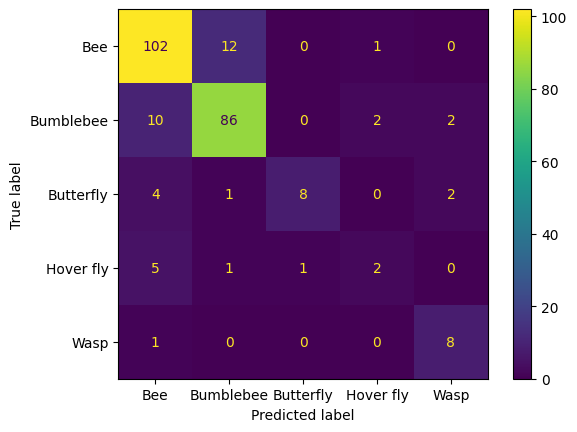

In [25]:
# with newton-cg
log = Pipeline([
    ('model', LogisticRegression(solver='newton-cg', random_state=RANDOM_STATE))
])
evaluate_classifier(log, X, y, cv=cv, n_jobs=1)

Accuracy: 0.8588709677419355
Precision: 0.8575671423616273
Recall: 0.8588709677419355
F1 Score: 0.8514740223103164
              precision    recall  f1-score   support

         Bee       0.85      0.91      0.88       115
   Bumblebee       0.88      0.91      0.89       100
   Butterfly       0.89      0.53      0.67        15
   Hover fly       0.75      0.33      0.46         9
        Wasp       0.86      0.67      0.75         9

    accuracy                           0.86       248
   macro avg       0.84      0.67      0.73       248
weighted avg       0.86      0.86      0.85       248



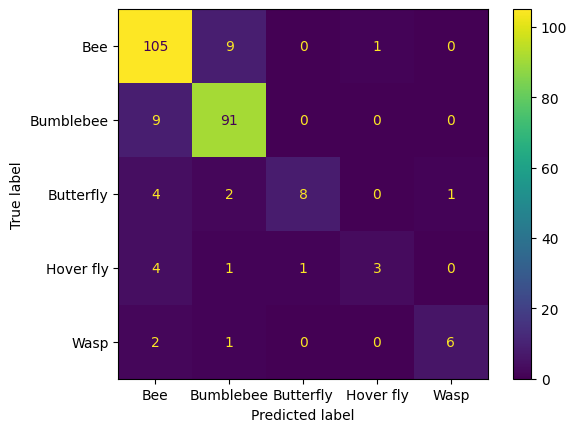

In [33]:
# with liblinear
log = Pipeline([
    ('model', LogisticRegression(solver='liblinear', random_state=RANDOM_STATE))
])
evaluate_classifier(log, X, y, cv=cv, n_jobs=1)

Performance of logistic regression on transformed data (with different criterias to optimize)

Accuracy: 0.8266129032258065
Precision: 0.8231290886532822
Recall: 0.8266129032258065
F1 Score: 0.8237400353898905
              precision    recall  f1-score   support

         Bee       0.87      0.87      0.87       115
   Bumblebee       0.86      0.89      0.87       100
   Butterfly       0.73      0.53      0.62        15
   Hover fly       0.25      0.22      0.24         9
        Wasp       0.60      0.67      0.63         9

    accuracy                           0.83       248
   macro avg       0.66      0.64      0.64       248
weighted avg       0.82      0.83      0.82       248



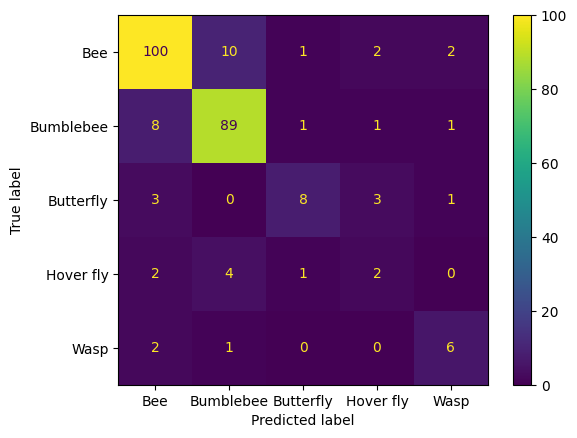

''

In [39]:
try_logistic_with_transformations(X, y, best_transforms_for_linear_dict, 'f_classif', df_results_dict, solver='liblinear',
                                  columns_to_apply_to=None,min_score=0)
''

Accuracy: 0.7943548387096774
Precision: 0.7904839936089936
Recall: 0.7943548387096774
F1 Score: 0.7914720709426086
              precision    recall  f1-score   support

         Bee       0.83      0.80      0.81       115
   Bumblebee       0.82      0.89      0.86       100
   Butterfly       0.85      0.73      0.79        15
   Hover fly       0.00      0.00      0.00         9
        Wasp       0.62      0.56      0.59         9

    accuracy                           0.79       248
   macro avg       0.62      0.60      0.61       248
weighted avg       0.79      0.79      0.79       248



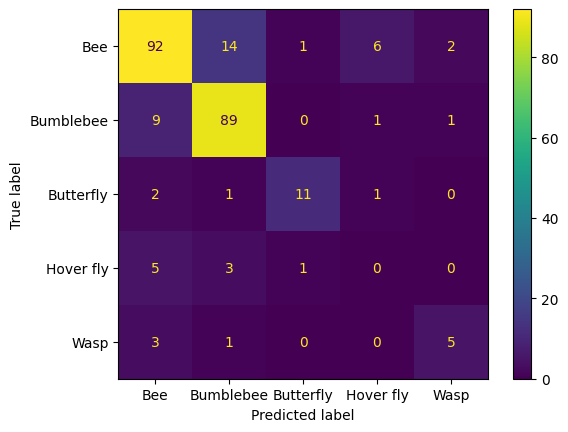

''

In [45]:
try_logistic_with_transformations(X, y, best_transforms_for_linear_dict, 'chi2', df_results_dict, solver='liblinear',
                                  columns_to_apply_to=None,min_score=0)
''

Accuracy: 0.7983870967741935
Precision: 0.7988811543679054
Recall: 0.7983870967741935
F1 Score: 0.7974696307156662
              precision    recall  f1-score   support

         Bee       0.81      0.84      0.83       115
   Bumblebee       0.88      0.86      0.87       100
   Butterfly       0.73      0.53      0.62        15
   Hover fly       0.22      0.22      0.22         9
        Wasp       0.50      0.56      0.53         9

    accuracy                           0.80       248
   macro avg       0.63      0.60      0.61       248
weighted avg       0.80      0.80      0.80       248



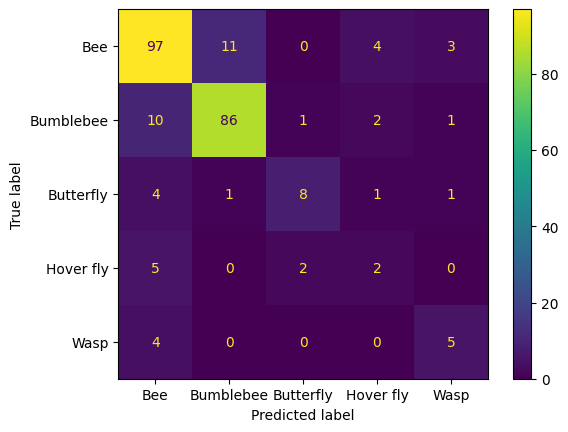

''

In [ ]:
try_logistic_with_transformations(X, y, best_transforms_for_linear_dict, 'logistic_regression', df_results_dict, solver='liblinear',
                                  columns_to_apply_to=None, min_score=0)
''

Accuracy: 0.8104838709677419
Precision: 0.808707757296467
Recall: 0.8104838709677419
F1 Score: 0.8085725997102112
              precision    recall  f1-score   support

         Bee       0.82      0.85      0.83       115
   Bumblebee       0.85      0.85      0.85       100
   Butterfly       0.83      0.67      0.74        15
   Hover fly       0.44      0.44      0.44         9
        Wasp       0.57      0.44      0.50         9

    accuracy                           0.81       248
   macro avg       0.70      0.65      0.67       248
weighted avg       0.81      0.81      0.81       248



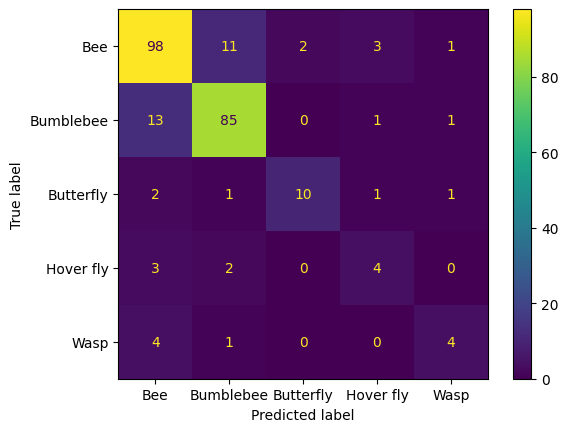

''

In [49]:
try_logistic_with_transformations(X, y, best_transforms_for_linear_dict, 'pearson', df_results_dict, solver='liblinear',
                                  columns_to_apply_to=None, min_score=0)
''

This automatic optimisation doesn't seem to work so we'll try some manual transformations on the most important features that we saw were skewed during visualisation.

Accuracy: 0.8790322580645161
Precision: 0.8690529560631624
Recall: 0.8790322580645161
F1 Score: 0.86781774922618
              precision    recall  f1-score   support

         Bee       0.86      0.93      0.90       115
   Bumblebee       0.90      0.93      0.92       100
   Butterfly       0.83      0.67      0.74        15
   Hover fly       0.50      0.11      0.18         9
        Wasp       1.00      0.78      0.88         9

    accuracy                           0.88       248
   macro avg       0.82      0.68      0.72       248
weighted avg       0.87      0.88      0.87       248



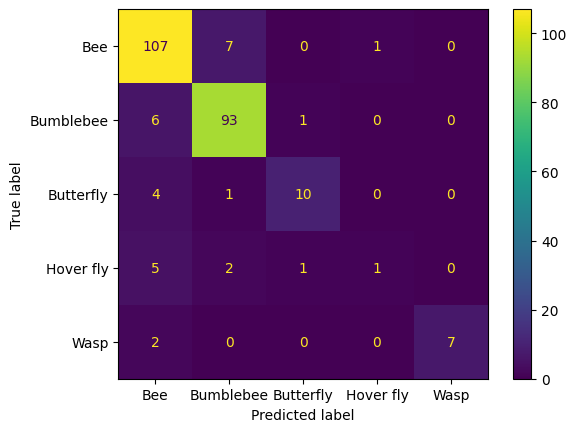

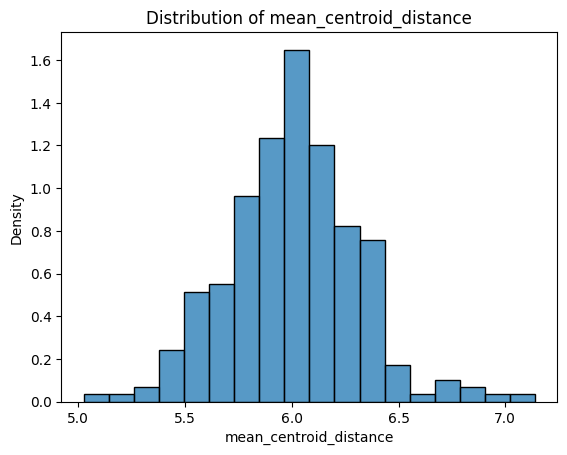

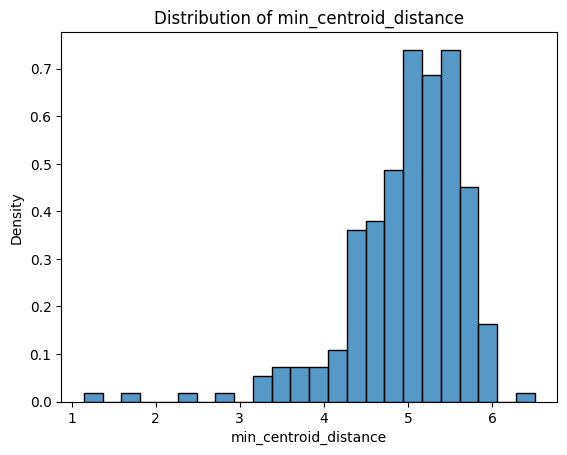

''

In [57]:
transf = {
    'mean_centroid_distance': safe_log,
    'min_centroid_distance': safe_log,
    #'std_centroid_distance': identity,
    #'max_centroid_distance': identity,
    #'kurtosis_centroid_distance': identity,
    #'skewness_centroid_distance': identity,
    #'aspect_ratio': identity,
    #'image_symmetry_index': identity,
    #'ellipse_angle': identity,
    #'hull_triangle_similarity': identity,
    #'green_rest_q1': identity,
    #'value_mask_q1': identity,
    #'blue_mask_median': identity,
    #'red_rest_min': identity,
    #'green_rest_median': identity,
    #'mask_entropy': identity
    #'rest_entropy': identity,
    #'body_parts_spread': identity
    #'nb_pixels_ratio': identity,
    }
try_logistic_with_transformations(X, y, transf, 'f_classif', df_results_dict, solver='liblinear',
    columns_to_apply_to=list(transf.keys()),min_score=0, transf_dict_contains_score=False,
        plot_distributions=True)
''

We tried many transformations but only those on mean_centroid_distance and min_centroid_distance worked. They were pretty effective, increasing accuracy by 2%. And we see that the distribution of mean_centroid_distance is now gaussian. We will try applying those in our final logistic regression model.

### c) For gaussian methods (Gaussian Naive Bayes, Linear Discriminant Analysis)

• Models that assume the features follow a gaussian distribution like gaussian naive bayes and linear discriminant analysis may benefit from transformations that normalize the data. We identified the following transformations : 
- Logarithmic Transformations: useful for skewed data, making distributions more symmetric.
- Square Root Transformations: Stabilizes variance and reduces skewness.
- Box-Cox Transformation: Flexible transformation that can make data more Gaussian-like.
- Z-score Normalization: Standardizes features to have mean zero and unit variance.

• Then, to evaluate each transformation, we tried the following criterias:
- Shapiro-Wilk Test: A test for normality.
- Anderson-Darling Test: Another test for normality.
- Skewness and Kurtosis: Metrics that describe the shape of the distribution.
- The cross-validated accuracy of a Gaussian Naive Bayes model on the transformed column

In [22]:
def find_weird_features(X, threshold=10):
    weird_features = []
    for feature in X.columns:
        data = X[feature]
        kurt = kurtosis(data)
        skewness = skew(data)
        if np.abs(kurt) > threshold or np.abs(skewness) > threshold:
            weird_features.append(feature)
    return weird_features
find_weird_features(X)

['nb_pixels_ratio',
 'mask_area',
 'hull_area',
 'ellipse_variance',
 'body_parts_mean_length',
 'red_rest_max',
 'green_mask_min',
 'blue_mask_min',
 'blue_rest_max',
 'blue_mask_q1',
 'hue_mask_max',
 'hue_rest_max',
 'hue_rest_median',
 'hue_mask_q1',
 'hue_rest_q1',
 'saturation_mask_min',
 'saturation_rest_min',
 'saturation_mask_max',
 'value_mask_max',
 'value_rest_max',
 'fourier_descriptor_real_0']

In [75]:
gaussian_transformations = {
    'log': safe_log,
    'sqrt': sqrt_transform,
    'square': lambda x: power_transform_factory(x, 2),
    'inverse': lambda x: power_transform_factory(x, -1),
    'box_cox': box_cox_transform,
    'z_score': z_score_normalization,
    'yeo_johnson': yeo_johnson_transform,
    #'rank': rank_transform,
}

In [223]:
scorings = ['anderson', 'shapiro', 'skewness_kurtosis','gaussian_bayes']
best_transforms_for_gaussian_dict = {}
df_results_for_gaussian_dict = {}
for scoring in scorings:
    best_transforms_for_gaussian_dict[scoring], df_results_for_gaussian_dict[scoring] = find_best_transformation(X, y_encoded, 
                                                                    gaussian_transformations, scoring=scoring, display_df=False, verbose=False)
    # Statistics on transformed data
    transformed_X = MultiColumnCachedTransformer(best_transforms_for_gaussian_dict[scoring], verbose=True).fit_transform(X)
    display(HTML(transformed_X.describe().to_html()))

131 transformations above mean (-inf) out of 133 (98.50%)
Counts for each transformation for scoring anderson: transformation_name
inverse        72
square         47
identity        6
sqrt            3
yeo_johnson     2
box_cox         1
Name: count, dtype: int64
Information on scores :  count     133.0
unique    132.0
top        -inf
freq        2.0
Name: score, dtype: float64
Transforming data of shape (248, 133)
Transformed data shape: (248, 131)
Kept columns after transformation: Index(['nb_pixels_ratio', 'image_symmetry_index', 'mask_bb_symmetry_index',
       'roundness', 'mean_centroid_distance', 'std_centroid_distance',
       'max_centroid_distance', 'min_centroid_distance',
       'skewness_centroid_distance', 'kurtosis_centroid_distance',
       ...
       'fourier_descriptor_imag_5', 'fourier_descriptor_real_6',
       'fourier_descriptor_imag_6', 'fourier_descriptor_real_7',
       'fourier_descriptor_imag_7', 'fourier_descriptor_real_8',
       'fourier_descriptor_imag_8

,nb_pixels_ratio,image_symmetry_index,mask_bb_symmetry_index,roundness,mean_centroid_distance,std_centroid_distance,max_centroid_distance,min_centroid_distance,skewness_centroid_distance,kurtosis_centroid_distance,aspect_ratio,mask_area,mask_perimeter,hull_area,hull_to_insect_area_ratio,hull_convexity,hull_triangle_similarity,ellipse_angle,ellipse_axis_ratio,ellipse_eccentricity,ellipse_variance,axis_least_inertia_x,axis_least_inertia_y,rectangularity,body_parts_mean_length,body_parts_max_length,body_parts_std_length,body_parts_spread,rest_entropy,mask_entropy,red_mask_min,red_rest_min,red_mask_max,red_rest_max,red_mask_mean,red_rest_mean,red_mask_median,red_rest_median,red_mask_std,red_rest_std,red_mask_q1,red_rest_q1,red_mask_q3,red_rest_q3,green_mask_min,green_rest_min,green_mask_max,green_rest_max,green_mask_mean,green_rest_mean,green_mask_median,green_rest_median,green_mask_std,green_rest_std,green_mask_q1,green_rest_q1,green_mask_q3,green_rest_q3,blue_mask_min,blue_rest_min,blue_mask_max,blue_rest_max,blue_mask_mean,blue_rest_mean,blue_mask_median,blue_rest_median,blue_mask_std,blue_rest_std,blue_mask_q1,blue_rest_q1,blue_mask_q3,blue_rest_q3,hue_mask_max,hue_rest_max,hue_mask_mean,hue_rest_mean,hue_mask_median,hue_rest_median,hue_mask_std,hue_rest_std,hue_mask_q1,hue_rest_q1,hue_mask_q3,hue_rest_q3,saturation_mask_max,saturation_rest_max,saturation_mask_mean,saturation_rest_mean,saturation_mask_median,saturation_rest_median,saturation_mask_std,saturation_rest_std,saturation_mask_q1,saturation_rest_q1,saturation_mask_q3,saturation_rest_q3,value_mask_min,value_rest_min,value_mask_max,value_rest_max,value_mask_mean,value_rest_mean,value_mask_median,value_rest_median,value_mask_std,value_rest_std,value_mask_q1,value_rest_q1,value_mask_q3,value_rest_q3,fourier_descriptor_real_0,fourier_descriptor_imag_0,fourier_descriptor_real_1,fourier_descriptor_imag_1,fourier_descriptor_real_2,fourier_descriptor_imag_2,fourier_descriptor_real_3,fourier_descriptor_imag_3,fourier_descriptor_real_4,fourier_descriptor_imag_4,fourier_descriptor_real_5,fourier_descriptor_imag_5,fourier_descriptor_real_6,fourier_descriptor_imag_6,fourier_descriptor_real_7,fourier_descriptor_imag_7,fourier_descriptor_real_8,fourier_descriptor_imag_8,fourier_descriptor_real_9,fourier_descriptor_imag_9,orthogonal_lines_ratio
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,248.000000,2.480000e+02,2.480000e+02,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,2.480000e+02,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000
mean,0.000805,1851.125046,0.021009,0.007135,0.002594,0.009523,0.001599,0.011202,17.984121,4.706004,1.258172,4.633528e+11,0.000118,1.766149e-06,1.488407,2.821259,1.317601,0.045962,1.452212,1.569

59 transformations above mean (0.4380251095364429) out of 133 (44.36%)
Counts for each transformation for scoring shapiro: transformation_name
identity       48
box_cox        30
yeo_johnson    15
log            13
sqrt           13
square          7
inverse         7
Name: count, dtype: int64
Information on scores :  count     133.0
unique    122.0
top         1.0
freq       10.0
Name: score, dtype: float64
Transforming data of shape (248, 133)
Transformed data shape: (248, 118)
Kept columns after transformation: Index(['nb_pixels_ratio', 'image_symmetry_index', 'mask_bb_symmetry_index',
       'roundness', 'mean_centroid_distance', 'std_centroid_distance',
       'max_centroid_distance', 'min_centroid_distance',
       'skewness_centroid_distance', 'kurtosis_centroid_distance',
       ...
       'fourier_descriptor_imag_5', 'fourier_descriptor_real_6',
       'fourier_descriptor_imag_6', 'fourier_descriptor_real_7',
       'fourier_descriptor_imag_7', 'fourier_descriptor_real_8',
   

,nb_pixels_ratio,image_symmetry_index,mask_bb_symmetry_index,roundness,mean_centroid_distance,std_centroid_distance,max_centroid_distance,min_centroid_distance,skewness_centroid_distance,kurtosis_centroid_distance,aspect_ratio,mask_area,mask_perimeter,hull_area,hull_to_insect_area_ratio,hull_convexity,ellipse_axis_ratio,ellipse_eccentricity,ellipse_variance,rectangularity,body_parts_mean_length,body_parts_max_length,body_parts_std_length,body_parts_spread,rest_entropy,mask_entropy,red_rest_min,red_mask_max,red_rest_max,red_mask_mean,red_rest_mean,red_mask_median,red_rest_median,red_mask_std,red_rest_std,red_mask_q1,red_rest_q1,red_mask_q3,red_rest_q3,green_mask_max,green_rest_max,green_mask_mean,green_rest_mean,green_mask_median,green_mask_std,green_rest_std,green_mask_q1,green_rest_q1,green_mask_q3,green_rest_q3,blue_mask_max,blue_rest_max,blue_mask_mean,blue_rest_mean,blue_mask_median,blue_rest_median,blue_mask_std,blue_rest_std,blue_mask_q1,blue_rest_q1,blue_mask_q3,blue_rest_q3,hue_mask_max,hue_rest_max,hue_mask_mean,hue_rest_mean,hue_rest_median,hue_mask_std,hue_rest_std,hue_rest_q1,saturation_mask_min,saturation_rest_min,saturation_mask_max,saturation_rest_max,saturation_mask_mean,saturation_rest_mean,saturation_mask_median,saturation_rest_median,saturation_mask_std,saturation_rest_std,saturation_mask_q1,saturation_mask_q3,saturation_rest_q3,value_mask_min,value_rest_min,value_mask_max,value_rest_max,value_mask_mean,value_rest_mean,value_mask_median,value_rest_median,value_mask_std,value_rest_std,value_mask_q1,value_rest_q1,value_mask_q3,value_rest_q3,fourier_descriptor_real_0,fourier_descriptor_imag_0,fourier_descriptor_real_1,fourier_descriptor_imag_1,fourier_descriptor_real_2,fourier_descriptor_imag_2,fourier_descriptor_real_3,fourier_descriptor_imag_3,fourier_descriptor_real_4,fourier_descriptor_imag_4,fourier_descriptor_real_5,fourier_descriptor_imag_5,fourier_descriptor_real_6,fourier_descriptor_imag_6,fourier_descriptor_real_7,fourier_descriptor_imag_7,fourier_descriptor_real_8,fourier_descriptor_imag_8,fourier_descriptor_real_9,fourier_descriptor_imag_9,orthogonal_lines_ratio
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,2.480000e+02,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.0,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,0.014079,4.882888,3.915147,0.045039,423.526414,119.773730,689.853260,34.655389,0.064967,-0.860634,5.213978,13.039006,9450.399194,858.294956,0.691751,0.361271,1.944409,1.206190,10.639472,0.682214,6.624699,7.744528,3.483160,21.234839,378597.324328,4.520567e+08,3.462953,1.563192e+76,2.373204e+153,100.481076,12351.397190,95.822581,0.009941,5.159329,3.466198,56.294355,81.169355,13.519135,2.024603,243.733871,1.131959e+77,8.927964,12275.425766,75.201613,49.131364,3.646526,41.907258,7497.484039,115.854839,4.914315,6.273783e+62,2.964553e+153,8.375088,2

101 transformations above mean (0.6040068657464958) out of 133 (75.94%)
Counts for each transformation for scoring skewness_kurtosis: transformation_name
identity       43
yeo_johnson    42
box_cox        27
sqrt           10
inverse         5
log             3
square          3
Name: count, dtype: int64
Information on scores :  count     133.000000
unique    133.000000
top         0.558548
freq        1.000000
Name: score, dtype: float64
Transforming data of shape (248, 133)
Transformed data shape: (248, 124)
Kept columns after transformation: Index(['nb_pixels_ratio', 'image_symmetry_index', 'mask_bb_symmetry_index',
       'roundness', 'mean_centroid_distance', 'std_centroid_distance',
       'max_centroid_distance', 'min_centroid_distance',
       'skewness_centroid_distance', 'kurtosis_centroid_distance',
       ...
       'fourier_descriptor_imag_5', 'fourier_descriptor_real_6',
       'fourier_descriptor_imag_6', 'fourier_descriptor_real_7',
       'fourier_descriptor_imag_7', '

,nb_pixels_ratio,image_symmetry_index,mask_bb_symmetry_index,roundness,mean_centroid_distance,std_centroid_distance,max_centroid_distance,min_centroid_distance,skewness_centroid_distance,kurtosis_centroid_distance,aspect_ratio,mask_area,mask_perimeter,hull_area,hull_to_insect_area_ratio,hull_convexity,hull_triangle_similarity,ellipse_angle,ellipse_axis_ratio,ellipse_eccentricity,ellipse_variance,axis_least_inertia_x,axis_least_inertia_y,rectangularity,body_parts_mean_length,body_parts_max_length,body_parts_std_length,body_parts_spread,rest_entropy,mask_entropy,red_mask_min,red_rest_min,red_mask_max,red_mask_mean,red_rest_mean,red_mask_median,red_rest_median,red_mask_std,red_rest_std,red_mask_q1,red_rest_q1,red_mask_q3,red_rest_q3,green_mask_min,green_rest_min,green_mask_max,green_rest_max,green_mask_mean,green_rest_mean,green_mask_median,green_rest_median,green_mask_std,green_rest_std,green_mask_q1,green_rest_q1,green_mask_q3,green_rest_q3,blue_mask_min,blue_rest_min,blue_mask_max,blue_mask_mean,blue_rest_mean,blue_mask_median,blue_rest_median,blue_mask_std,blue_rest_std,blue_mask_q1,blue_rest_q1,blue_mask_q3,blue_rest_q3,hue_mask_mean,hue_rest_mean,hue_mask_median,hue_rest_median,hue_mask_std,hue_rest_std,hue_mask_q1,hue_rest_q1,hue_mask_q3,hue_rest_q3,saturation_rest_max,saturation_mask_mean,saturation_rest_mean,saturation_mask_median,saturation_rest_median,saturation_mask_std,saturation_rest_std,saturation_mask_q1,saturation_rest_q1,saturation_mask_q3,saturation_rest_q3,value_mask_min,value_rest_min,value_mask_mean,value_rest_mean,value_mask_median,value_rest_median,value_mask_std,value_rest_std,value_mask_q1,value_rest_q1,value_mask_q3,value_rest_q3,fourier_descriptor_real_0,fourier_descriptor_imag_0,fourier_descriptor_real_1,fourier_descriptor_imag_1,fourier_descriptor_real_2,fourier_descriptor_imag_2,fourier_descriptor_real_3,fourier_descriptor_imag_3,fourier_descriptor_real_4,fourier_descriptor_imag_4,fourier_descriptor_real_5,fourier_descriptor_imag_5,fourier_descriptor_real_6,fourier_descriptor_imag_6,fourier_descriptor_real_7,fourier_descriptor_imag_7,fourier_descriptor_real_8,fourier_descriptor_imag_8,fourier_descriptor_real_9,fourier_descriptor_imag_9,orthogonal_lines_ratio
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,0.014079,4.882888,7.060991,0.077793,20.330325,4.182709,25.927691,175.592526,0.064967,-0.860634,5.213978,11.276475,18.083774,10.948219,0.691751,0.599648,0.781569,88.111157,1.944409,1.206190,0.656969,0.062935,-0.433839,0.386429,3.215907,4.638834,3.483160,5.076439,378597.616745,4.520568e+08,1.402806,3.462953,1.563192e+76,5.696451,3.748809,18.143644,28.761875,5.159329,1795.001398,5.764829,81.169

67 transformations above mean (0.514895100654863) out of 133 (50.38%)
Counts for each transformation for scoring gaussian_bayes: transformation_name
identity       106
box_cox          9
inverse          8
log              6
sqrt             2
square           1
yeo_johnson      1
Name: count, dtype: int64
Information on scores :  count     133.000000
unique     80.000000
top         0.541935
freq        5.000000
Name: score, dtype: float64
Transforming data of shape (248, 133)
Transformed data shape: (248, 127)
Kept columns after transformation: Index(['nb_pixels_ratio', 'image_symmetry_index', 'mask_bb_symmetry_index',
       'roundness', 'mean_centroid_distance', 'std_centroid_distance',
       'max_centroid_distance', 'min_centroid_distance',
       'skewness_centroid_distance', 'kurtosis_centroid_distance',
       ...
       'fourier_descriptor_imag_5', 'fourier_descriptor_real_6',
       'fourier_descriptor_imag_6', 'fourier_descriptor_real_7',
       'fourier_descriptor_imag_7',

,nb_pixels_ratio,image_symmetry_index,mask_bb_symmetry_index,roundness,mean_centroid_distance,std_centroid_distance,max_centroid_distance,min_centroid_distance,skewness_centroid_distance,kurtosis_centroid_distance,aspect_ratio,mask_area,mask_perimeter,hull_area,hull_to_insect_area_ratio,hull_convexity,hull_triangle_similarity,ellipse_angle,ellipse_axis_ratio,ellipse_eccentricity,ellipse_variance,axis_least_inertia_x,axis_least_inertia_y,rectangularity,body_parts_mean_length,body_parts_max_length,body_parts_std_length,body_parts_spread,rest_entropy,mask_entropy,red_mask_min,red_rest_min,red_rest_max,red_mask_mean,red_rest_mean,red_mask_median,red_rest_median,red_mask_std,red_rest_std,red_mask_q1,red_rest_q1,red_mask_q3,red_rest_q3,green_mask_min,green_rest_min,green_mask_max,green_rest_max,green_mask_mean,green_rest_mean,green_mask_median,green_rest_median,green_mask_std,green_rest_std,green_mask_q1,green_rest_q1,green_mask_q3,green_rest_q3,blue_mask_min,blue_rest_min,blue_mask_mean,blue_rest_mean,blue_mask_median,blue_rest_median,blue_mask_std,blue_rest_std,blue_mask_q1,blue_rest_q1,blue_mask_q3,blue_rest_q3,hue_mask_max,hue_rest_max,hue_mask_mean,hue_rest_mean,hue_mask_median,hue_rest_median,hue_mask_std,hue_rest_std,hue_mask_q1,hue_rest_q1,hue_mask_q3,hue_rest_q3,saturation_rest_min,saturation_mask_max,saturation_rest_max,saturation_mask_mean,saturation_rest_mean,saturation_mask_median,saturation_rest_median,saturation_mask_std,saturation_rest_std,saturation_mask_q1,saturation_rest_q1,saturation_mask_q3,saturation_rest_q3,value_mask_min,value_rest_min,value_mask_mean,value_rest_mean,value_mask_median,value_rest_median,value_mask_std,value_rest_std,value_mask_q1,value_rest_q1,value_mask_q3,value_rest_q3,fourier_descriptor_real_0,fourier_descriptor_imag_0,fourier_descriptor_real_1,fourier_descriptor_imag_1,fourier_descriptor_real_2,fourier_descriptor_imag_2,fourier_descriptor_real_3,fourier_descriptor_imag_3,fourier_descriptor_real_4,fourier_descriptor_imag_4,fourier_descriptor_real_5,fourier_descriptor_imag_5,fourier_descriptor_real_6,fourier_descriptor_imag_6,fourier_descriptor_real_7,fourier_descriptor_imag_7,fourier_descriptor_real_8,fourier_descriptor_imag_8,fourier_descriptor_real_9,fourier_descriptor_imag_9,orthogonal_lines_ratio
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,0.022845,41.187193,50.575431,0.077793,423.526414,119.773730,689.853260,175.592526,0.064967,-0.583103,0.819957,5.477155e+05,9450.399194,8.087671e+05,0.691751,0.361271,0.781569,88.111157,0.716987,0.671443,0.095011,-0.494271,-0.433839,0.470985,846.210668,0.000495,6.582316,462.757579,7.039302,7.311328,5.1129

In [53]:
def try_gaussian_bayes_with_transformations(X, y, transformations_dict, scoring, df_results_dict, **kwargs):
    model = GaussianNB()
    return try_model_with_transformations(model, X, y, transformations_dict, scoring, df_results_dict, **kwargs)
def try_lda_with_transformations(X, y, transformations_dict, scoring, df_results_dict, **kwargs):
    model = LinearDiscriminantAnalysis()
    return try_model_with_transformations(model, X, y, transformations_dict, scoring, df_results_dict, **kwargs)

Accuracy: 0.7016129032258065
Precision: 0.7818088525732875
Recall: 0.7016129032258065
F1 Score: 0.7323325504265985
              precision    recall  f1-score   support

         Bee       0.80      0.68      0.73       115
   Bumblebee       0.84      0.71      0.77       100
   Butterfly       0.87      0.87      0.87        15
   Hover fly       0.11      0.44      0.18         9
        Wasp       0.53      0.89      0.67         9

    accuracy                           0.70       248
   macro avg       0.63      0.72      0.64       248
weighted avg       0.78      0.70      0.73       248



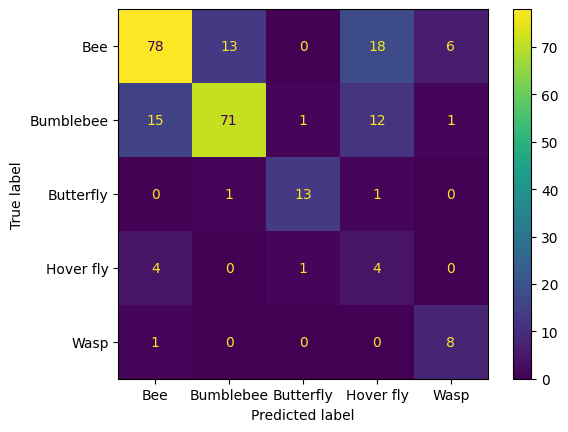

In [127]:
# Try gaussian bayes without transformation as a baseline
gb = imbPipeline([
    ('model', GaussianNB())
])
evaluate_classifier(gb, X, y, cv=cv, n_jobs=1)

In [293]:
try_gaussian_bayes_with_transformations(X.drop([ellipse_features + fourier_features + shape_features + body_parts_features], axis=1), y, best_transforms_for_gaussian_dict, 'shapiro', df_results_for_gaussian_dict, verbose=False,
                                        columns_to_apply_to=ellipse_features + fourier_features, min_score=0)
''

KeyError: "[('ellipse_angle', 'ellipse_axis_ratio', 'ellipse_eccentricity', 'ellipse_variance', 'fourier_descriptor_real_0', 'fourier_descriptor_imag_0', 'fourier_descriptor_real_1', 'fourier_descriptor_imag_1', 'fourier_descriptor_real_2', 'fourier_descriptor_imag_2', 'fourier_descriptor_real_3', 'fourier_descriptor_imag_3', 'fourier_descriptor_real_4', 'fourier_descriptor_imag_4', 'fourier_descriptor_real_5', 'fourier_descriptor_imag_5', 'fourier_descriptor_real_6', 'fourier_descriptor_imag_6', 'fourier_descriptor_real_7', 'fourier_descriptor_imag_7', 'fourier_descriptor_real_8', 'fourier_descriptor_imag_8', 'fourier_descriptor_real_9', 'fourier_descriptor_imag_9', 'roundness', 'rectangularity', 'orthogonal_lines_ratio', 'hull_convexity', 'hull_to_insect_area_ratio', 'hull_triangle_similarity', 'body_parts_mean_length', 'body_parts_max_length', 'body_parts_std_length', 'body_parts_spread')] not found in axis"

Accuracy: 0.6935483870967742
Precision: 0.7859886830742863
Recall: 0.6935483870967742
F1 Score: 0.7271147139695526
              precision    recall  f1-score   support

         Bee       0.81      0.65      0.72       115
   Bumblebee       0.84      0.71      0.77       100
   Butterfly       0.87      0.87      0.87        15
   Hover fly       0.13      0.56      0.21         9
        Wasp       0.50      0.89      0.64         9

    accuracy                           0.69       248
   macro avg       0.63      0.73      0.64       248
weighted avg       0.79      0.69      0.73       248



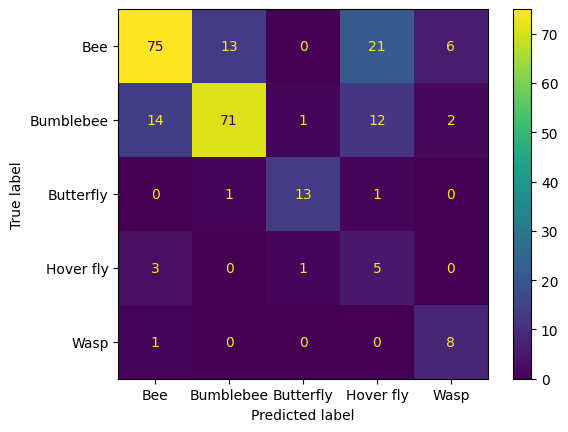

,score,transformation_name,above_mean,acceptance
column,,,,
value_rest_max,18.997543,yeo_johnson,True,True
blue_rest_max,18.126251,box_cox,True,True
saturation_mask_max,15.431659,identity,True,True
value_mask_max,15.090280,sqrt,True,True
red_rest_max,14.746664,identity,True,True
blue_mask_min,14.373373,box_cox,True,True
blue_mask_max,13.702769,yeo_johnson,True,True
saturation_rest_max,12.714076,yeo_johnson,True,True
red_mask_max,12.611160,sqrt,True,True


In [180]:
try_gaussian_bayes_with_transformations(X, y, best_transforms_for_gaussian_dict, 'anderson', df_results_for_gaussian_dict, min_score=12,
                                        columns_to_apply_to=ellipse_features + fourier_features, verbose=False)

Accuracy: 0.375
Precision: 0.22057560137457044
Recall: 0.375
F1 Score: 0.2772769301895516
              precision    recall  f1-score   support

         Bee       0.47      0.80      0.60       115
   Bumblebee       0.00      0.00      0.00       100
   Butterfly       0.00      0.00      0.00        15
   Hover fly       0.00      0.00      0.00         9
        Wasp       0.02      0.11      0.03         9

    accuracy                           0.38       248
   macro avg       0.10      0.18      0.13       248
weighted avg       0.22      0.38      0.28       248



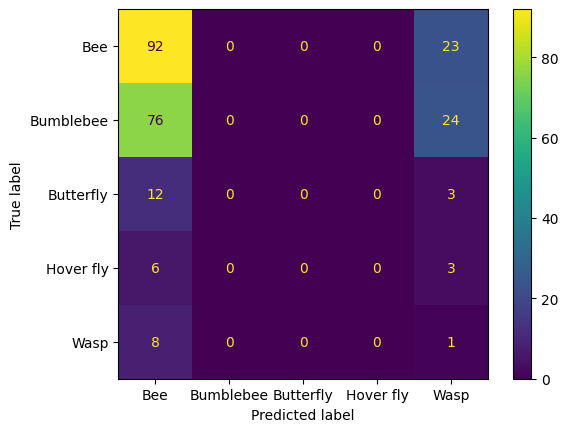

,score,transformation_name,above_mean,acceptance
column,,,,
min_centroid_distance,0.701895,identity,True,True
mean_centroid_distance,0.685282,identity,True,True
nb_pixels_ratio,0.681129,identity,True,True
mask_area,0.681129,identity,True,True
hull_area,0.660363,identity,True,True
blue_mask_q1,0.657258,log,True,True
value_mask_q1,0.652056,identity,True,True
green_mask_q1,0.637097,box_cox,True,True
red_mask_q1,0.637097,sqrt,True,True


In [185]:
try_gaussian_bayes_with_transformations(X, y, best_transforms_for_gaussian_dict, 'gaussian_bayes', df_results_for_gaussian_dict, min_score=0.2)

Accuracy: 0.7137096774193549
Precision: 0.7899498509081051
Recall: 0.7137096774193549
F1 Score: 0.7433650054699339
              precision    recall  f1-score   support

         Bee       0.80      0.70      0.74       115
   Bumblebee       0.85      0.72      0.78       100
   Butterfly       0.87      0.87      0.87        15
   Hover fly       0.12      0.44      0.19         9
        Wasp       0.57      0.89      0.70         9

    accuracy                           0.71       248
   macro avg       0.64      0.72      0.65       248
weighted avg       0.79      0.71      0.74       248



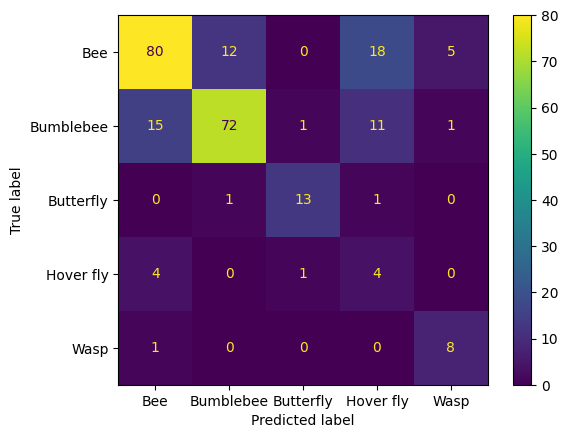

''

In [264]:
# positive impact on : fourier_features + ellipse_features
try_gaussian_bayes_with_transformations(X, y, best_transforms_for_gaussian_dict, 'skewness_kurtosis', df_results_for_gaussian_dict, verbose=False,
                                        columns_to_apply_to=fourier_features + shape_features + ellipse_features + ratio_features + inertia_features, min_score=0)
''

Accuracy: 0.6854838709677419
Precision: 0.6996729424423594
Recall: 0.6854838709677419
F1 Score: 0.6880929276613651
              precision    recall  f1-score   support

         Bee       0.73      0.71      0.72       115
   Bumblebee       0.72      0.74      0.73       100
   Butterfly       0.88      0.47      0.61        15
   Hover fly       0.18      0.22      0.20         9
        Wasp       0.38      0.56      0.45         9

    accuracy                           0.69       248
   macro avg       0.58      0.54      0.54       248
weighted avg       0.70      0.69      0.69       248



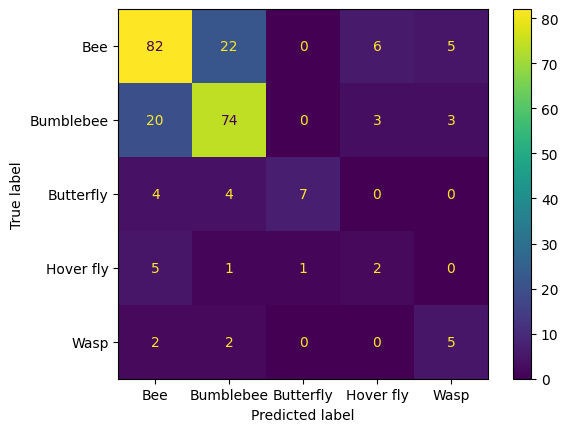

In [274]:
lda = imbPipeline([
    ('model', LinearDiscriminantAnalysis())
])
evaluate_classifier(lda, X, y, cv=cv, n_jobs=1)

Accuracy: 0.3024193548387097
Precision: 0.5775335567422261
Recall: 0.3024193548387097
F1 Score: 0.3592192063868222
              precision    recall  f1-score   support

         Bee       0.72      0.20      0.31       115
   Bumblebee       0.55      0.41      0.47       100
   Butterfly       0.25      0.27      0.26        15
   Hover fly       0.05      0.56      0.09         9
        Wasp       0.11      0.22      0.15         9

    accuracy                           0.30       248
   macro avg       0.34      0.33      0.26       248
weighted avg       0.58      0.30      0.36       248



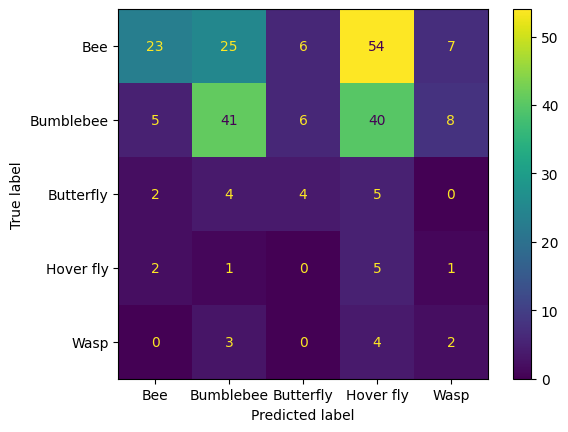

''

In [285]:
try_lda_with_transformations(X, y, best_transforms_for_gaussian_dict, 'shapiro', df_results_for_gaussian_dict, verbose=False,
                                        columns_to_apply_to=shape_features + fourier_features + body_parts_features + ellipse_features, min_score=0.1)
''

Accuracy: 0.7338709677419355
Precision: 0.7424912816041849
Recall: 0.7338709677419355
F1 Score: 0.7344802744792677
              precision    recall  f1-score   support

         Bee       0.79      0.77      0.78       115
   Bumblebee       0.75      0.78      0.76       100
   Butterfly       0.78      0.47      0.58        15
   Hover fly       0.20      0.22      0.21         9
        Wasp       0.50      0.78      0.61         9

    accuracy                           0.73       248
   macro avg       0.60      0.60      0.59       248
weighted avg       0.74      0.73      0.73       248



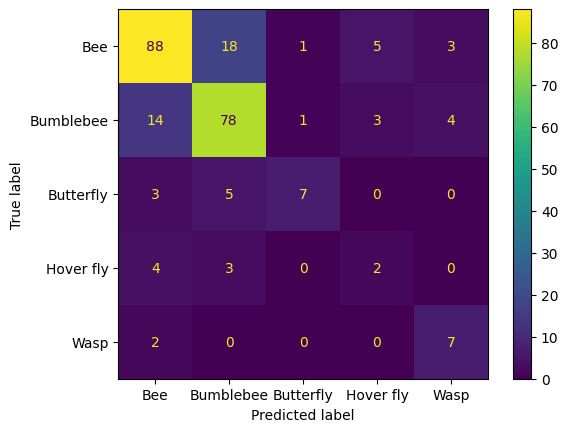

''

In [291]:
try_lda_with_transformations(X, y, best_transforms_for_gaussian_dict, 'anderson', df_results_for_gaussian_dict, verbose=False,
                                        columns_to_apply_to=shape_features + fourier_features + body_parts_features, min_score=0)
''

Accuracy: 0.16129032258064516
Precision: 0.22047346514047866
Recall: 0.16129032258064516
F1 Score: 0.1585701889676821
              precision    recall  f1-score   support

         Bee       0.47      0.25      0.33       115
   Bumblebee       0.00      0.00      0.00       100
   Butterfly       0.06      0.73      0.11        15
   Hover fly       0.00      0.00      0.00         9
        Wasp       0.00      0.00      0.00         9

    accuracy                           0.16       248
   macro avg       0.11      0.20      0.09       248
weighted avg       0.22      0.16      0.16       248



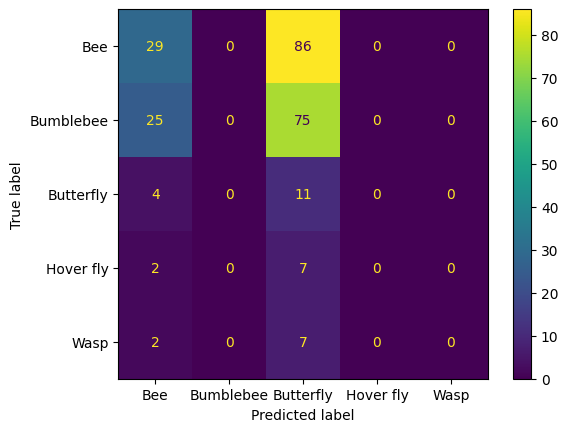

,score,transformation_name,above_mean,acceptance
column,,,,
min_centroid_distance,0.715524,identity,True,True
mean_centroid_distance,0.698589,identity,True,True
nb_pixels_ratio,0.694355,identity,True,True
mask_area,0.694355,identity,True,True
hull_area,0.673185,identity,True,True
value_mask_q1,0.664718,identity,True,True
blue_mask_q1,0.657258,log,True,True
red_mask_q1,0.647782,identity,True,True
green_mask_q1,0.647782,identity,True,True


In [292]:
try_lda_with_transformations(X, y, best_transforms_for_gaussian_dict, 'gaussian_bayes', df_results_for_gaussian_dict, min_score=0.2)

The only decent scoring seems to be 'anderson', and even that scoring doesn't increase the performance a lot

## 2 - New features from interactions between features

We will try to create new interactions between features and select features that are the most important. We will try to find some automatically first, then try to be inventive and find some ourselves

### a) Automated test of new features with XGBoost

We will generate new feature interactions in the following form : A+B, A-B, A/B, A*B. We didn't test it on all features at the same time but only on some groups on  because there would have been way too many features to compute and the model would have taken forever to work. The groups we tried are the geometry features together, the color and shape features together, and the centroid distance features together. Once we try the model on all the new features, we look at the 50 most important features and try to add to our dataset with our initial features the features that were the most important for the model or seem the most meaningful. We will only keep the features that increase all our scores (accuracy, precision, recall).

In [61]:
model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='logloss'
)

In [ ]:
X_interactions = generate_feature_interactions(X[shape_features + color_features])
X_extended = pd.concat([X, X_interactions], axis=1)
model = evaluate_features(model,X_extended, y_encoded)

Mean Cross-Validation Accuracy: 0.8225806451612903
Model Trained on Full Dataset


15445 Features Before Selection
Selected Features Based on Importance:
['hue_mask_std_div_value_mask_min', 'blue_mask_q3_div_saturation_mask_std', 'hue_mask_mean_x_saturation_mask_median', 'red_rest_std_plus_red_rest_median', 'red_mask_q3_div_blue_mask_median', 'green_mask_mean_x_green_rest_q1', 'hue_mask_mean_div_hue_rest_mean', 'hue_mask_median_minus_hue_rest_q3', 'red_mask_q3_minus_blue_mask_median', 'green_mask_median_div_value_mask_q1', 'hull_to_insect_area_ratio_x_saturation_mask_std', 'hue_rest_std_div_value_mask_q1', 'green_rest_median_plus_hue_mask_q1', 'hull_convexity_x_value_mask_median', 'saturation_mask_std_x_value_rest_mean', 'hull_to_insect_area_ratio_x_value_mask_std', 'saturation_rest_q3_div_value_mask_min', 'green_rest_q1_minus_value_rest_q1', 'red_mask_max_minus_red_rest_std', 'orthogonal_lines_ratio_x_hue_mask_std', 'red_rest_std_div_saturation_mask_std', 'rectangularity_x_red_rest_q1', 'red_rest_min_div_blue_rest_min', 'green_mask_std_x_saturation_mask_q1', 'green_

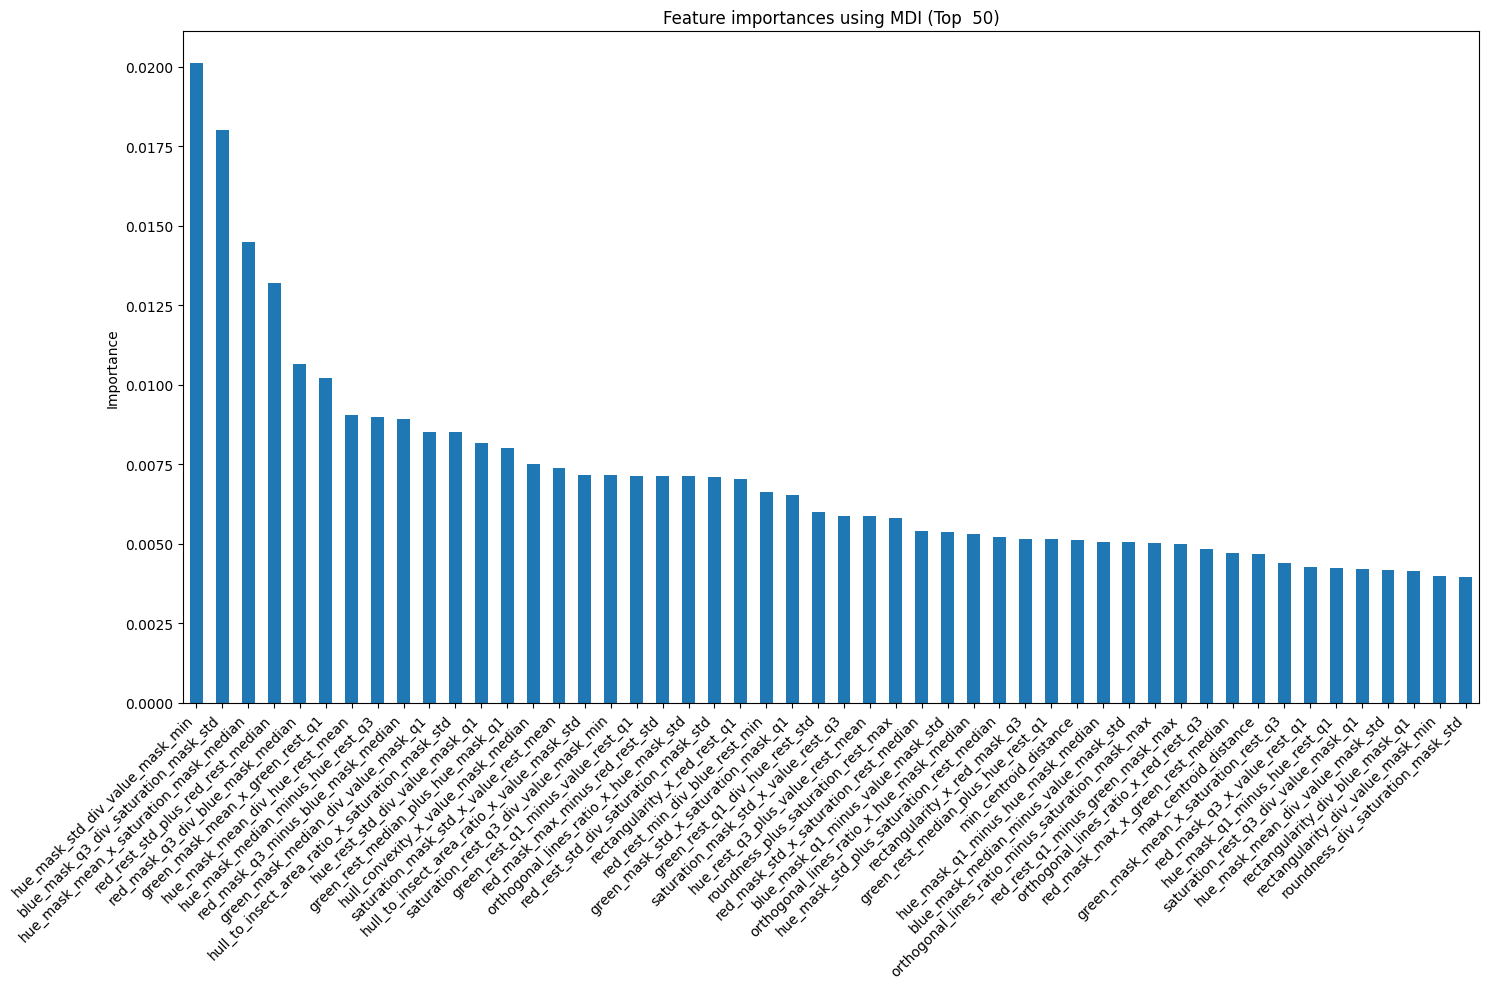

In [ ]:
X_selected = select_features(model,X_extended, threshold=0.01, n_final_features=50)

Let' first run a model on untransformed data for comparison :

Accuracy: 0.8306451612903226
Precision: 0.8080167184175723
Recall: 0.8306451612903226
F1 Score: 0.8102437651692556
              precision    recall  f1-score   support

         Bee       0.80      0.91      0.85       115
   Bumblebee       0.86      0.88      0.87       100
   Butterfly       0.91      0.67      0.77        15
   Hover fly       0.00      0.00      0.00         9
        Wasp       1.00      0.33      0.50         9

    accuracy                           0.83       248
   macro avg       0.71      0.56      0.60       248
weighted avg       0.81      0.83      0.81       248



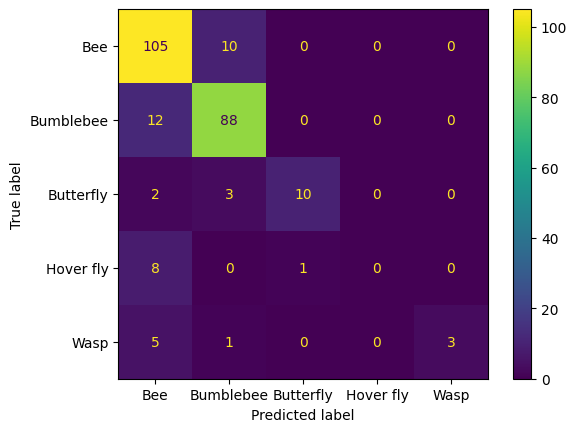

In [107]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='logloss'
)
pipe = imbPipeline([
    ('model', xgb)
])
evaluate_classifier(pipe,X, y, cv=cv, n_jobs=-1)

Then let's test a model with the same parameters on the original features + features we decided to add

Accuracy: 0.8508064516129032
Precision: 0.8267235129653271
Recall: 0.8508064516129032
F1 Score: 0.8324880511730148
              precision    recall  f1-score   support

         Bee       0.80      0.93      0.86       115
   Bumblebee       0.91      0.89      0.90       100
   Butterfly       0.85      0.73      0.79        15
   Hover fly       0.00      0.00      0.00         9
        Wasp       1.00      0.44      0.62         9

    accuracy                           0.85       248
   macro avg       0.71      0.60      0.63       248
weighted avg       0.83      0.85      0.83       248



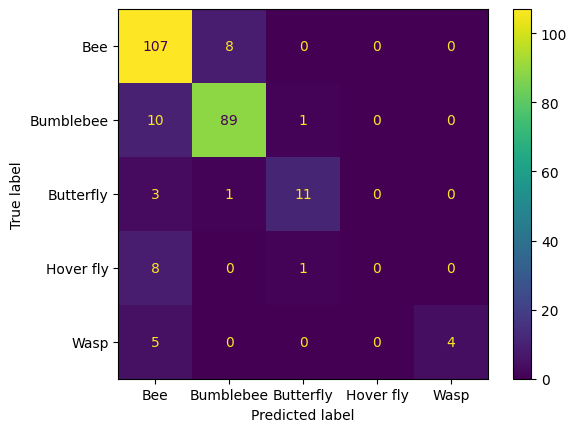

In [117]:
# Features found automatically
X_final = X.copy()
X_final['hull_to_insect_area_ratio_x_value_mask_std'] = X_final['hull_to_insect_area_ratio'] * X_final['value_mask_std']
X_final['roundness_div_hull_area'] = X_final['roundness'] / (X_final['hull_area'] + 0.0001)
X_final['min_centroid_distance_x_rectangularity'] = X_final['min_centroid_distance'] * X_final['rectangularity']
X_final['mean_centroid_distance_x_max_centroid_distance'] = X_final['mean_centroid_distance'] * X_final['max_centroid_distance']
X_final['nb_pixels_ratio_div_hull_triangle_similarity'] = X_final['nb_pixels_ratio'] / (X_final['hull_triangle_similarity'] + 0.0001)

evaluate_classifier(pipe,X_final, y, cv=cv, n_jobs=-1)

We increased all scores by around 2%. The features seem useful

### b) Our own new feature ideas from our existing features

Accuracy: 0.8508064516129032
Precision: 0.8270100195503421
Recall: 0.8508064516129032
F1 Score: 0.8325207145241101
              precision    recall  f1-score   support

         Bee       0.80      0.92      0.86       115
   Bumblebee       0.90      0.90      0.90       100
   Butterfly       0.92      0.73      0.81        15
   Hover fly       0.00      0.00      0.00         9
        Wasp       1.00      0.44      0.62         9

    accuracy                           0.85       248
   macro avg       0.72      0.60      0.64       248
weighted avg       0.83      0.85      0.83       248



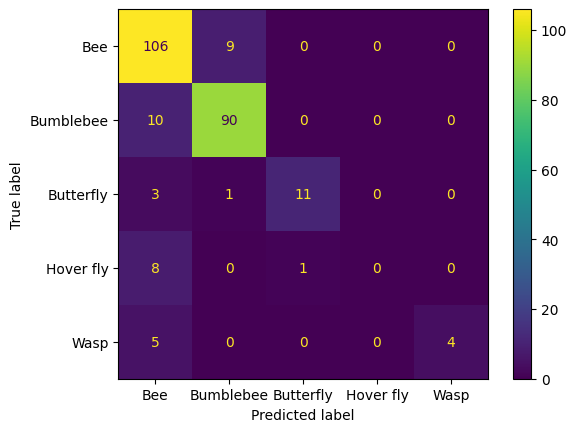

In [139]:
# Features added by ourselves
epsilon = 1e-6
X_final['blue_contrast'] = X_final['blue_mask_mean'] / (X_final['blue_rest_mean'] + epsilon)
X_final['shape_texture_index'] = X_final['roundness'] * X_final['mask_entropy']
X_final['saturation_weighted_aspect_ratio'] = X_final['aspect_ratio'] * X_final['saturation_mask_mean']

# Features that didn't work well for performance
#X_final['Red Contrast'] = X_final['red_mask_mean'] / (X_final['red_rest_mean'] + epsilon)
#X_final['Green Contrast'] = X_final['green_mask_mean'] / (X_final['green_rest_mean'] + epsilon)
#X_final['Saturation-Brightness Ratio'] = X_final['saturation_mask_mean'] / (X_final['value_mask_mean'] + epsilon)
#fourier_components = ['fourier_descriptor_real_', 'fourier_descriptor_imag_']
#X_final['fourier_shape_complexity'] = sum(X_final[f"{real_or_imag}{i}"]**2 for real_or_imag in fourier_components for i in range(1, 10))
#X_final['Color Diversity Index'] = (X_final['red_mask_std']**2 + X_final['green_mask_std']**2 + X_final['blue_mask_std']**2)**0.5
#X_final['Hue Variation Coefficient'] = X_final['hue_mask_std'] / (X_final['hue_mask_mean'] + epsilon)
#X_final['Relative Hue Saturation Product'] = X_final['hue_mask_mean'] * X_final['saturation_mask_mean']
#X_final['Elliptical Aspect Energy'] = X_final['ellipse_axis_ratio'] * X_final['std_centroid_distance']
#X_final['Inertia Color Alignment'] = X_final['axis_least_inertia_x'] * X_final['red_mask_mean'] + X_final['axis_least_inertia_y'] * X_final['blue_mask_mean']
#X_final['Perimeter-Area Ratio'] = X_final['mask_perimeter'] / (X_final['mask_area'] + epsilon)
#X_final['Ellipse Fit Quality'] = (np.pi * (X_final['ellipse_axis_ratio'] * 0.5) * (1 / X_final['ellipse_axis_ratio'] * 0.5)) / (X_final['mask_area'] + epsilon)
#X_final['Aspect Ratio Variability'] = X_final['aspect_ratio'] * X_final['std_centroid_distance']
#X_final['Convexity Defect Ratio'] = X_final['hull_area'] / (X_final['mask_area'] + epsilon)
#X_final['Major to Minor Axis Ratio'] = 1 / (X_final['ellipse_axis_ratio'] + epsilon)  # assuming ellipse_axis_ratio is major/minor
#X_final['Area Discrepancy Ratio'] = (X_final['aspect_ratio'] * X_final['mask_area']) / (X_final['mask_area'] + epsilon)
#X_final['Inertia Ratio'] = X_final['axis_least_inertia_x'] / (X_final['axis_least_inertia_y'] + epsilon)
#X_final['Overall Symmetry Index'] = X_final['image_symmetry_index'] * X_final['mask_bb_symmetry_index']
#X_final['Texture Uniformity Ratio'] = X_final['mask_entropy'] / (X_final['rest_entropy'] + epsilon)

evaluate_classifier(pipe,X_final, y, cv=cv, n_jobs=-1)

## 3. Dimensionality Reduction

(To complete)

In [140]:
X = X_final
columns = X.columns

Accuracy: 0.8266129032258065
Precision: 0.8012484696637531
Recall: 0.8266129032258065
F1 Score: 0.8074807958607418
              precision    recall  f1-score   support

         Bee       0.80      0.90      0.85       115
   Bumblebee       0.85      0.88      0.87       100
   Butterfly       0.82      0.60      0.69        15
   Hover fly       0.00      0.00      0.00         9
        Wasp       1.00      0.44      0.62         9

    accuracy                           0.83       248
   macro avg       0.69      0.57      0.60       248
weighted avg       0.80      0.83      0.81       248



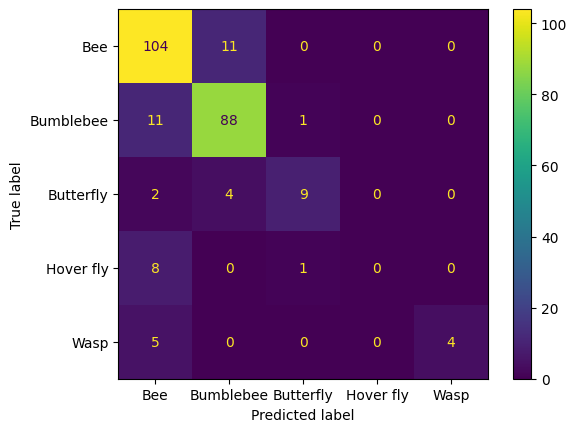

In [175]:
# Test without dimensionality reductor
classifier = LGBMClassifier(n_estimators=1000, learning_rate=0.05, num_leaves=32, verbose=-1, random_state=RANDOM_STATE)

classifier.fit(X, y)
pipe= Pipeline([
    ('model', classifier)
])
evaluate_classifier(pipe, X, y)

In [176]:
importances = classifier.feature_importances_

In [177]:
def create_dim_reductor(percent_treshold=65, n_components=0.8):
    # Identify less important features (e.g., bottom 25%)
    threshold = np.percentile(importances, percent_treshold)
    less_important_features = X.columns[importances < threshold]
    less_important_features_indices = [X.columns.get_loc(feature) for feature in less_important_features]
    # Apply PCA on less important features
    pca = PCA(n_components=n_components)
    return ColumnTransformer([('pca', pca, less_important_features_indices)], remainder='passthrough')
big_dim_reductor = create_dim_reductor(percent_treshold=65, n_components=0.8)
small_dim_reductor = create_dim_reductor(percent_treshold=40, n_components=0.83)
tiny_dim_reductor = create_dim_reductor(percent_treshold=20, n_components=0.86)

In [ ]:
pipe= Pipeline([
    ('model', classifier)
])
evaluate_classifier(pipe, X, y)

## 4. Feature Selection

Let's try a technique to find the best features automatically. If it works well we will use it for some models later

Baseline model

Accuracy: 0.8508064516129032
Precision: 0.8270100195503421
Recall: 0.8508064516129032
F1 Score: 0.8325207145241101
              precision    recall  f1-score   support

         Bee       0.80      0.92      0.86       115
   Bumblebee       0.90      0.90      0.90       100
   Butterfly       0.92      0.73      0.81        15
   Hover fly       0.00      0.00      0.00         9
        Wasp       1.00      0.44      0.62         9

    accuracy                           0.85       248
   macro avg       0.72      0.60      0.64       248
weighted avg       0.83      0.85      0.83       248



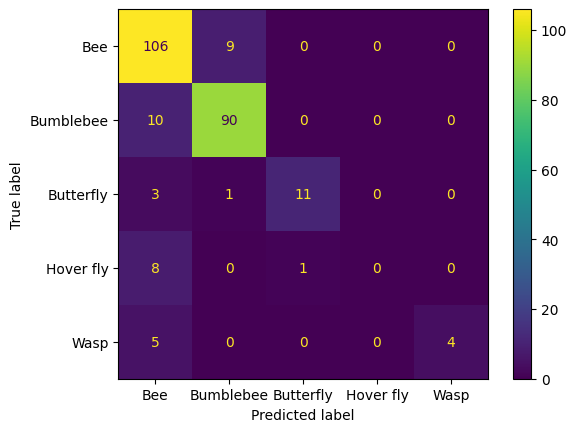

In [141]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='logloss'
)
pipe = imbPipeline([
    ('model', xgb)
])
evaluate_classifier(pipe,X, y, cv=cv, n_jobs=-1)

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_flags):
        self.feature_flags = feature_flags

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        selected_features = [feature for feature, flag in self.feature_flags.items() if flag]
        return X[selected_features]
feature_selector = FeatureSelector({col: True for col in X.columns})

Search space: {'select__nb_pixels_ratio': <hyperopt.pyll.base.Apply object at 0x000002392840C850>, 'select__image_symmetry_index': <hyperopt.pyll.base.Apply object at 0x0000023927D35350>, 'select__mask_bb_symmetry_index': <hyperopt.pyll.base.Apply object at 0x000002392759DF50>, 'select__roundness': <hyperopt.pyll.base.Apply object at 0x0000023928F47D10>, 'select__mean_centroid_distance': <hyperopt.pyll.base.Apply object at 0x00000239292FDE10>, 'select__std_centroid_distance': <hyperopt.pyll.base.Apply object at 0x00000239292FC4D0>, 'select__max_centroid_distance': <hyperopt.pyll.base.Apply object at 0x00000239292B9C90>, 'select__min_centroid_distance': <hyperopt.pyll.base.Apply object at 0x00000239292B9F90>, 'select__skewness_centroid_distance': <hyperopt.pyll.base.Apply object at 0x00000239292E2A10>, 'select__kurtosis_centroid_distance': <hyperopt.pyll.base.Apply object at 0x00000239292E2050>, 'select__aspect_ratio': <hyperopt.pyll.base.Apply object at 0x00000239292E0F10>, 'select__ma

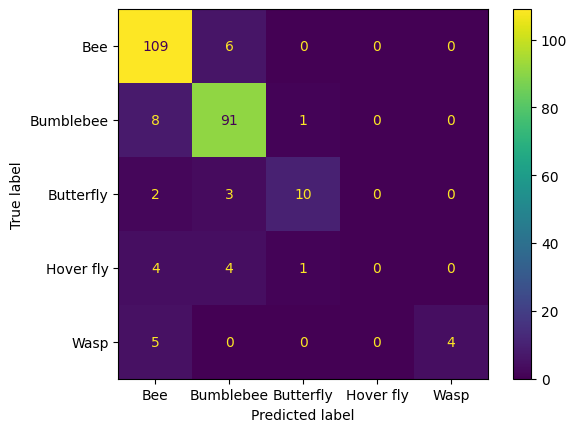

In [63]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='logloss'
)
space = {}
prefix = 'select__feature_flags__'
pipe = imbPipeline([
    ('feature_selector', feature_selector),
    ('model', xgb)
])
best_params = optimize_classifier(X,pipe, {}, {}, max_evals=100, scoring='accuracy', n_jobs=-1, search_features=True)
evaluate_classifier(pipe,X, y, cv=cv, n_jobs=-1)

It improved the score quite a bit with only a few iterations. We will use it

# B - Handling Dataset Imbalance

## 1. Data Augmentation Techniques

Data augmentation techniques like smote or adasyn can help reduce the imbalance in our data. Considering the very few number of samples for the minority classes, undersampling is not a viable option - we would have to heavily reduce the number of samples from the majority classes. instead, we are going to try oversampling the minority classes. The number of samples we will add for each minority class will be determined later when we will optimize the parameters of pipelines that include our data augmentation technique.

In [64]:
# Creating SMOTE and sampling strategy search space
smote = SMOTE(random_state=RANDOM_STATE, n_jobs=-1)
def create_sampling_strategy(factor_range=(1.4, 3.0), model='smote'):
    """
    Create a dynamic sampling strategy search space based on class counts and a factor range.
    :param class_counts: A pandas Series with index as class labels and values as counts.
    :param factor_range: A tuple specifying the min and max factors to multiply with class counts.
    :param step: Step size for the hp.quniform function.
    :return: A dictionary suitable for hyperopt's search space.
    """
    strategy = {}
    if True:
        unique, counts = np.unique(y_encoded, return_counts=True)
        class_counts = dict(zip(unique, counts))
    else:
        class_counts = y.value_counts()
    for class_label, count in class_counts.items():
        if (count < 50) and (count != 1):
            min_samples = math.ceil(count * factor_range[0])
            max_samples = math.ceil(count * factor_range[1])
            # Ensure there is a range to search
            if min_samples != max_samples:
                strategy[f'{model}__strategy__{class_label}'] = hp.uniformint(
                    f'sampling_{class_label}', min_samples, max_samples)
    if model == 'smote':
        strategy[f'{model}__k_neighbors'] = hp.choice('k_neighbors', [3, 4, 5, 6])
    elif model == 'adasyn':
        strategy[f'{model}__n_neighbors'] = hp.choice('n_neighbors', [3, 4, 5, 6])
    return strategy
smote_sampling_strategy_space = create_sampling_strategy(model='smote')

In [65]:
# Creating ADASYN 
adasyn_sampling_strategy_space = create_sampling_strategy(model='adasyn')
adasyn = ADASYN(random_state=RANDOM_STATE, n_jobs=-1)

In [ ]:
def validate_float32(X_transformed):
    """
    Check if each column in the DataFrame can be safely converted to float32.

    Args:
    - X_transformed (DataFrame): The DataFrame containing transformed data.

    Returns:
    - dict: Information about each column's ability to be represented as float32.
    """
    validation_results = {}
    for column in X_transformed.columns:
        col_data = X_transformed[column]
        col_min = col_data.min()
        col_max = col_data.max()
        
        # Check for NaN and infinity values
        has_nan = np.isnan(col_data).any()
        has_inf = np.isinf(col_data).any()
        
        # Check if the range of data is within the float32 precision
        can_represent = np.all(np.isfinite(np.float32(col_data)))
        
        # Report the results
        validation_results[column] = {
            'min': col_min,
            'max': col_max,
            'has_nan': has_nan,
            'has_inf': has_inf,
            'can_represent_float32': can_represent
        }
        
        # Print summary for each column
        print(f"Column: {column}")
        print(f"  Min value: {col_min}")
        print(f"  Max value: {col_max}")
        print(f"  Contains NaN: {has_nan}")
        print(f"  Contains Inf: {has_inf}")
        print(f"  Can represent as float32: {can_represent}\n")

    return validation_results

validation_results = validate_float32(X)
validation_results

## 2. Replacing minority classes by 'other'

We'll prepare 2 different target variables for our model where we replace minor classes with 'Other'. We will see which one works when evaluating our models on the data we have.
- y3 for target with 3 classes : Bee, Bumblebee, Other --> regrouped all minority classes  for way better balance
- y5 for target with 5 classes : Bee, Bumblebee, Wasp, Butterfly and Other --> regrouped minority classes that our models struggle to predict (Dragonfly having only 1 sample, and our models having low scores on hover fly), and data augmentation techniques discussed previously can be used

In [191]:
y = data['bug_type']
alt_y = data['species']
X = data.drop(['species','bug_type'], axis=1)
X.head()

,nb_pixels_ratio,image_symmetry_index,mask_bb_symmetry_index,roundness,mean_centroid_distance,std_centroid_distance,max_centroid_distance,min_centroid_distance,skewness_centroid_distance,kurtosis_centroid_distance,aspect_ratio,mask_area,mask_perimeter,hull_area,hull_to_insect_area_ratio,hull_convexity,hull_triangle_similarity,ellipse_angle,ellipse_axis_ratio,ellipse_eccentricity,ellipse_variance,axis_least_inertia_x,axis_least_inertia_y,rectangularity,body_parts_mean_length,body_parts_max_length,body_parts_std_length,body_parts_spread,rest_entropy,mask_entropy,red_mask_min,red_rest_min,red_mask_max,red_rest_max,red_mask_mean,red_rest_mean,red_mask_median,red_rest_median,red_mask_std,red_rest_std,red_mask_q1,red_rest_q1,red_mask_q3,red_rest_q3,green_mask_min,green_rest_min,green_mask_max,green_rest_max,green_mask_mean,green_rest_mean,green_mask_median,green_rest_median,green_mask_std,green_rest_std,green_mask_q1,green_rest_q1,green_mask_q3,green_rest_q3,blue_mask_min,blue_rest_min,blue_mask_max,blue_rest_max,blue_mask_mean,blue_rest_mean,blue_mask_median,blue_rest_median,blue_mask_std,blue_rest_std,blue_mask_q1,blue_rest_q1,blue_mask_q3,blue_rest_q3,hue_mask_max,hue_rest_max,hue_mask_mean,hue_rest_mean,hue_mask_median,hue_rest_median,hue_mask_std,hue_rest_std,hue_mask_q1,hue_rest_q1,hue_mask_q3,hue_rest_q3,saturation_mask_min,saturation_rest_min,saturation_mask_max,saturation_rest_max,saturation_mask_mean,saturation_rest_mean,saturation_mask_median,saturation_rest_median,saturation_mask_std,saturation_rest_std,saturation_mask_q1,saturation_rest_q1,saturation_mask_q3,saturation_rest_q3,value_mask_min,value_rest_min,value_mask_max,value_rest_max,value_mask_mean,value_rest_mean,value_mask_median,value_rest_median,value_mask_std,value_rest_std,value_mask_q1,value_rest_q1,value_mask_q3,value_rest_q3,fourier_descriptor_real_0,fourier_descriptor_imag_0,fourier_descriptor_real_1,fourier_descriptor_imag_1,fourier_descriptor_real_2,fourier_descriptor_imag_2,fourier_descriptor_real_3,fourier_descriptor_imag_3,fourier_descriptor_real_4,fourier_descriptor_imag_4,fourier_descriptor_real_5,fourier_descriptor_imag_5,fourier_descriptor_real_6,fourier_descriptor_imag_6,fourier_descriptor_real_7,fourier_descriptor_imag_7,fourier_descriptor_real_8,fourier_descriptor_imag_8,fourier_descriptor_real_9,fourier_descriptor_imag_9,orthogonal_lines_ratio,mask_compactness,hue_mask_min,hue_rest_min
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.007199,65.842518,70.059270,0.046706,245.172338,55.348483,362.548639,127.671981,-0.057930,-0.817833,0.811060,172773,6818,265227.5,0.651414,0.286969,0.826408,4.100518,0.878376,0.477971,0.099935,-0.840749,0.541425,0.502645,434.179165,1566.469267,545.078940,252.452196,7.460814,6.967513,5,1,203,255,66.750522,107.403577,54,128,47.329372,61.073311,26,43,99,156,3,2,199,255,53.387028,105.378123,36,123,44.415601,58.068684,17,49,81,151,0,0,186,255,38.786193,84.573068,23,85,35.298702,57.198890,13,28,54,132,178,179,22.955340,42.776885,14,27,35.494402,46.076375,10,21,20,38,0,0,255,255,113.963825,66.078872,115.0,51,41.474470,50.351267,83,26,143,102,5,3,203,255,66.826408,109.176003,55,128,47.295039,59.737595,26,50,99,156,0.802350,0.596853,-0.025349,-0.008629,-0.013720,0.006373,-0.001826,-0.004257,-0.010642,0.004364,-0.001702,0.008064,-0.001693,0.002286,-0.003509,0.004708,-0.000954,0.001356,-0.002313,0.000987,0.679289,NaN,NaN,NaN
2,0.008306,68.896841,40.143673,0.048440,279.998031,85.163883,478.802953,108.009513,-0.063210,-0.616582,0.652482,199332,7191,350945.5,0.567986,0.320907,0.997932,5.416759,0.568091,0.822966,0.090493,-0.965743,0.259500,0.426842,632.800093,4440.118453,1357.730195,350.976352,7.471152,6.811326,2,0,248,255,62.015547,101.106455,54,120,41.367330,61.737563,25,36,95,151,2,1,251,255,50.140876,98.708295,32,116,41.829106,58.443197,16,42,81,145,0,0,244,255,34.095609,74.862067,18,65,33.493150,56.037654,10,24,53,120,179,179,24.3442